In [6]:
!pip install dlib
!pip install mtcnn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.9 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.5 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 KB 21.6 MB/s eta 0:00:00


In [ ]:
!pip install 

In [12]:
import cv2
import os
import numpy as np
#from google.colab.patches import cv2_imshow
import time
import os
#from mtcnn.mtcnn import MTCNN
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import random
random.seed(99)

In [13]:
path0, = !echo $PWD
print(path0)
path0 = path0 + '/ComputerVisionDQuispe/models/'
modelFile = f'{path0}/res10_300x300_ssd_iter_140000.caffemodel'
configFile = f'{path0}/deploy.prototxt'
mname = "DNN"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
detector_mtcnn = MTCNN()

/home/aldo/maestria/dist_comp_vision


In [24]:
os.path.isfile( "/home/aldo/maestria/dist_comp_vision//ComputerVisionDQuispe/models//deploy.prototxt")

True

In [25]:
# wider face dataset
# https://drive.google.com/file/d/1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T/view

In [14]:
rootpath = "/home/aldo/maestria/dist_comp_vision/"#os.listdir("/home/aldo/maestria/dist_comp_vision/LFW/lfw-deepfunneled/lfw-deepfunneled/")

In [15]:
val_bbox_path = f"{rootpath}/WFD/wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt"
val_images = f"{rootpath}/WFD/wider_val/WIDER_val/images/"


def parse_wider_annotations(annotation_file):
    """
    Returns structure: { 'image_name.jpg': [[x, y, w, h], [x, y, w, h], ...] }
    """
    wider_data = {}
    
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
        
    i = 0
    while i < len(lines):
        filename = lines[i].strip() # filename
        i += 1
        
        try:
            num_faces = int(lines[i].strip()) # numer of faces
            i += 1
        except ValueError:
            
            break
            
        faces = []
        if num_faces == 0:
            # in case number of faces = 0 
            wider_data[filename] = []
            continue

        for _ in range(num_faces):
            # feature line: x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose
            # (x, y, w, h)
            line_data = lines[i].strip().split()
            x = int(line_data[0])
            y = int(line_data[1])
            w = int(line_data[2])
            h = int(line_data[3])
            
            # (x, y, w, h)
            faces.append([x, y, w, h])
            i += 1
            
        wider_data[filename] = faces
        
    return wider_data

In [16]:
# randomize images
ground_truth = parse_wider_annotations(val_bbox_path)

rnd_keys = list(ground_truth.keys())
random.shuffle(rnd_keys)
ground_truth = {k:ground_truth[k] for k in rnd_keys}

confidenceThreshold = 0.5
print(f"Etiquetas cargadas para {len(ground_truth)} imágenes.")

Etiquetas cargadas para 3226 imágenes.


In [11]:
for f in list(ground_truth.keys())[:5]:
    print(f"  {f}")

  5--Car_Accident/5_Car_Accident_Accident_5_77.jpg
  31--Waiter_Waitress/31_Waiter_Waitress_Waiter_Waitress_31_742.jpg
  2--Demonstration/2_Demonstration_Demonstrators_2_666.jpg
  26--Soldier_Drilling/26_Soldier_Drilling_Soldiers_Drilling_26_619.jpg
  16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_226.jpg


## Dummie model test: DNN & MTCNN

    DNN 1
    MTCNN 1
		 0.9822607636451721


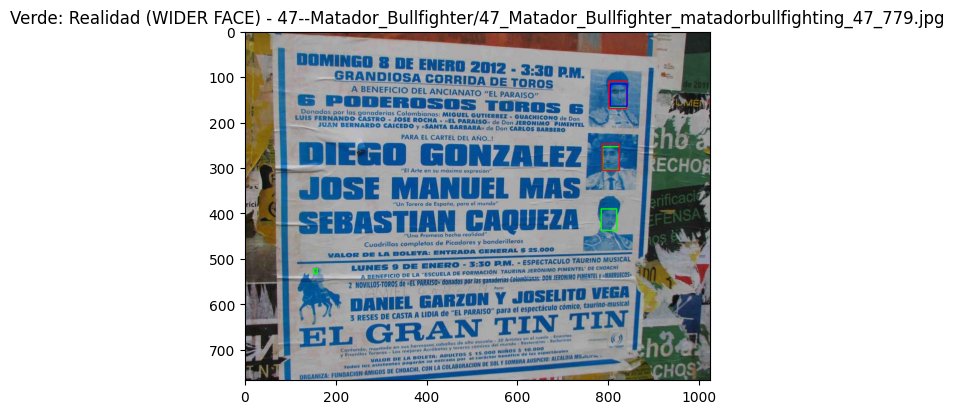

    DNN 1
    MTCNN 1
		 0.9998815059661865


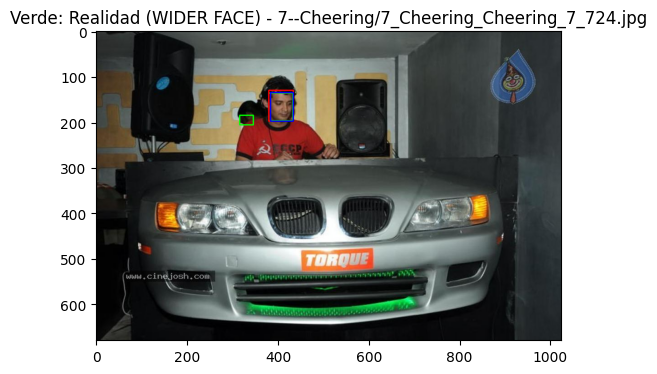

    DNN 1
    MTCNN 2
		 0.9968518614768982
		 0.9711928963661194


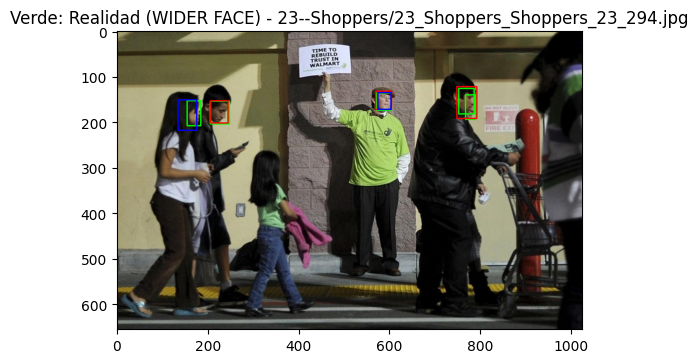

    DNN 1
    MTCNN 1
		 0.9933627843856812


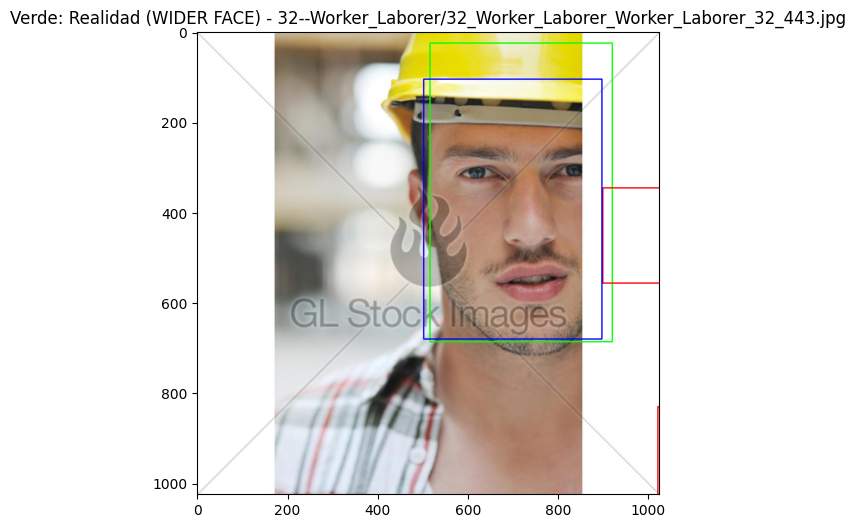

    DNN 1
    MTCNN 3
		 1.0
		 0.9999995231628418
		 0.9999642372131348


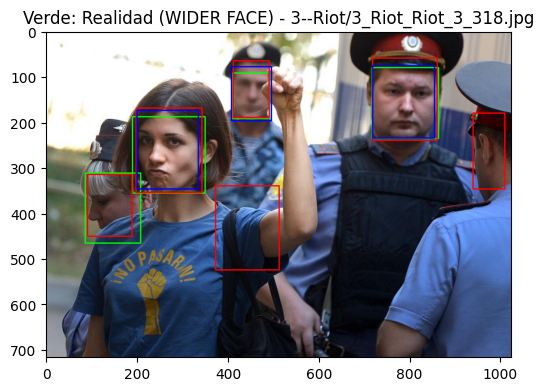

In [7]:
# iterate on images to test the model
count = 0
for img_path_rel, true_boxes in ground_truth.items():
    if count > 4: break # Solo probamos 3 para no saturar la salida
    
    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    img = img_bgr.copy()
    height_, width_ = img.shape[:2]
    if img_bgr is None:
        print(f"No se encontró: {full_path}")
        continue

    for box in true_boxes:
        x, y, w, h = box
        cv2.rectangle(img_bgr, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # applying models CNN & MTCNN
    # --- DNN
    
    #blob = cv2.dnn.blobFromImage(img_rgb, 1.0, (300,300), (104.0, 177.0, 123.0))
    blob = cv2.dnn.blobFromImage(img, 1.0, (width_, height_), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    detections = net.forward()
    print("    DNN", len(detections))
    detected_faces_count = 0
    for i in range(detections.shape[2]):
      confidence = detections[0, 0, i, 2] ## el tercer indice es el valor de confianza

      if confidence > confidenceThreshold:
        detected_faces_count += 1
        #counts += 1
        box_normalized = detections[0,0,i,3:7]
        box = box_normalized * np.array([width_, height_, width_, height_])
        (x, y, x1, y1) = box.astype('int')

        ## DIBUJA EL RECTANGULO
        cv2.rectangle(img_bgr, (x, y), (x1, y1), (0, 0, 255), 2)

    # --- MTCNN
    #img_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    result =  detector_mtcnn.detect_faces(img_rgb)
    print("    MTCNN", len(result))
    rectangles = []
    

    for face in result:
        confianza = face['confidence']
        print("\t\t", confianza)
        # filter by confidence
        if confianza > 0.50: 
            x, y, width, height = face['box']
            
            # avoid negative coord.
            x = max(0, x)
            y = max(0, y)
            x1 = x + width
            y1 = y + height
            cv2.rectangle(img_bgr, (x, y), (x1, y1), (255, 0, 0), 2)
            rectangles.append((x, y, x1, y1))
    
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Verde: Realidad (WIDER FACE) - {img_path_rel}")
    plt.show()
    
    count += 1

## First Analysis

In [17]:

def bb_intersection_over_union(boxA, boxB):
    # overlapping area coordenates
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # overlapping area
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # detected areas
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def calculate_image_stats(pred_boxes, gt_boxes, iou_thresh=0.5):
    """
    for a single image
    Compares and returns : True Positives, False Positives, False Negatives
    """
    tp = 0
    fp = 0
    fn = 0


    gt_pendientes = list(gt_boxes) 
    preds_pendientes = list(pred_boxes)
    
    # greedy matcher
    for pred in preds_pendientes:
        best_iou = 0
        best_gt_idx = -1
        
        for i, gt in enumerate(gt_pendientes):
            iou = bb_intersection_over_union(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i
        
        # evaluat overlapping percent - > if true TP
        if best_iou >= iou_thresh:
            tp += 1
            # remove GT from list
            gt_pendientes.pop(best_gt_idx)
        else:
            # False Positive
            fp += 1
            
    # remanent GTare FN false negatives
    fn = len(gt_pendientes)
    
    return tp, fp, fn
    

In [ ]:

CONF_THRESH_DNN = 0.5   # DNN confidence threshold
CONF_THRESH_MTCNN = 0.8 # Confidence threshold MTCNN
IOU_THRESH = 0.3      # overlapping threshold

# counter
stats = {
    'DNN':   {'TP': 0, 'FP': 0, 'FN': 0, 'TotalTime':.0},
    'MTCNN': {'TP': 0, 'FP': 0, 'FN': 0, 'TotalTime':.0}
}

print("Iniciando evaluación... ")

count = 0
limit = 100 # limiten number of images / None: allows all images
bar_spots = 50
bars_    = f" "*bar_spots
each =limit/bar_spots
percent_ = "{100*count/limit:3.2f} %"
for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count%each == 0:
        step = int(count/each)
        bars_ = "/"*step + " "*(bar_spots - step)+'|'
    print(bars_, f"{100*count/limit:3.2f} %", end="\r")
    #print( count/limit)
    #if count % 10 == 0: 
    #print(f"Procesando imagen {count}...", end="\r")
    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    height_, width_ = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Convertir Ground Truth a formato [x1, y1, x2, y2] para facilitar IoU
    gt_boxes = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])

    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (width_, height_), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    
    # --- DNN
    start_time = time.perf_counter() # Inicio cronómetro preciso
    detections = net.forward()
    end_time = time.perf_counter()   # Fin cronómetro
    
    stats['DNN']['TotalTime'] += (end_time - start_time) # Acumulamos la diferencia
    
    dnn_boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > CONF_THRESH_DNN:
            box = detections[0, 0, i, 3:7] * np.array([width_, height_, width_, height_])
            (x1, y1, x2, y2) = box.astype("int")
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(width_, x2), min(height_, y2)
            if x2 > x1 and y2 > y1:
                dnn_boxes.append([x1, y1, x2, y2])

    tp, fp, fn = calculate_image_stats(dnn_boxes, gt_boxes, IOU_THRESH)
    stats['DNN']['TP'] += tp
    stats['DNN']['FP'] += fp
    stats['DNN']['FN'] += fn


    # --- EVALUAR MTCNN (+ Tiempo)

    start_time = time.perf_counter()
    result = detector_mtcnn.detect_faces(img_rgb)
    end_time = time.perf_counter()
    
    stats['MTCNN']['TotalTime'] += (end_time - start_time)

    mtcnn_boxes = []
    for face in result:
        if face['confidence'] > CONF_THRESH_MTCNN:
            x, y, w, h = face['box']
            x1, y1 = max(0, x), max(0, y)
            x2, y2 = x1 + w, y1 + h
            mtcnn_boxes.append([x1, y1, x2, y2])

    tp, fp, fn = calculate_image_stats(mtcnn_boxes, gt_boxes, IOU_THRESH)
    stats['MTCNN']['TP'] += tp
    stats['MTCNN']['FP'] += fp
    stats['MTCNN']['FN'] += fn
print()
print("Evaluación completada.")

def print_report(nombre, datos, total_imagenes):
    tp = datos['TP']
    fp = datos['FP']
    fn = datos['FN']
    total_time = datos['TotalTime']
    
    # precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Time
    avg_time = total_time / total_imagenes if total_imagenes > 0 else 0
    fps = 1.0 / avg_time if avg_time > 0 else 0
    
    print('')
    print(f"=========================================")
    print(f" REPORT: {nombre}")
    print(f"=========================================")
    print(f"--- RENDIMIENTO ---")
    print(f" PRECISION:  {precision:.4f} (Calidad)")
    print(f" RECALL:     {recall:.4f} (Cobertura)")
    print(f" F1-SCORE:   {f1_score:.4f}")
    print(f" TP: {tp} | FP: {fp} | FN: {fn}")
    print(f"--- VELOCIDAD ---")
    print(f" Tiempo Total:   {total_time:.2f} seg")
    print(f" Latencia Prom:  {avg_time*1000:.1f} ms/img")
    print(f" FPS Estimados:  {fps:.2f} FPS")
    print(f"\n")


print(f"\nEvaluación finalizada sobre {count} imágenes.\n")


In [27]:
print_report("OpenCV DNN", stats['DNN'], count)
print_report("MTCNN", stats['MTCNN'], count)



 REPORT: OpenCV DNN
--- RENDIMIENTO ---
 PRECISION:  0.8797 (Calidad)
 RECALL:     0.2422 (Cobertura)
 F1-SCORE:   0.3798
 TP: 395 | FP: 54 | FN: 1236
--- VELOCIDAD ---
 Tiempo Total:   9.67 seg
 Latencia Prom:  96.7 ms/img
 FPS Estimados:  10.35 FPS



 REPORT: MTCNN
--- RENDIMIENTO ---
 PRECISION:  0.9618 (Calidad)
 RECALL:     0.3857 (Cobertura)
 F1-SCORE:   0.5505
 TP: 629 | FP: 25 | FN: 1002
--- VELOCIDAD ---
 Tiempo Total:   55.60 seg
 Latencia Prom:  556.0 ms/img
 FPS Estimados:  1.80 FPS




In [18]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

### General simple metrics


Generando Reportes Gráficos...


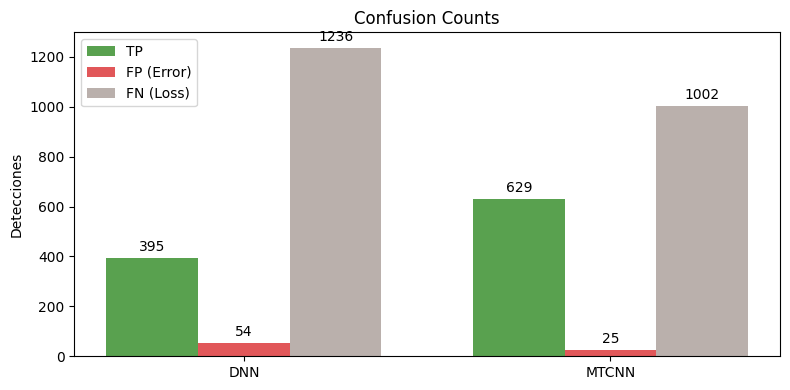

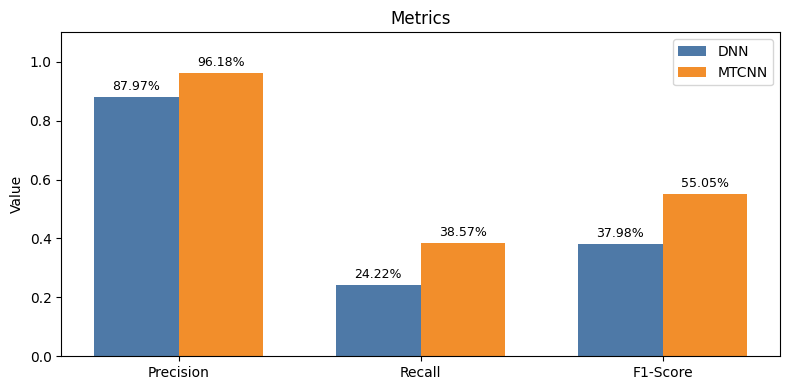

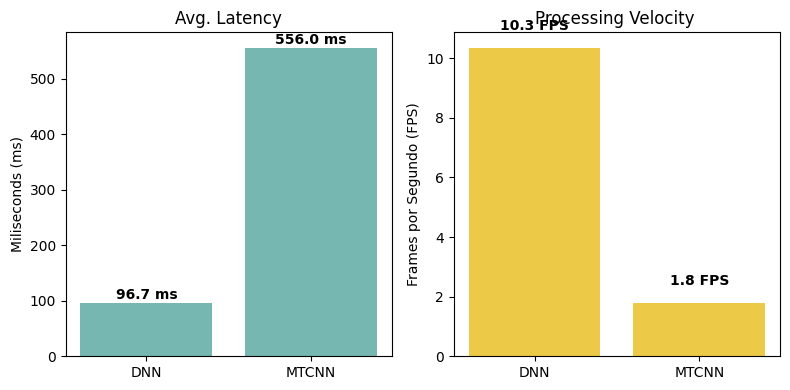

In [28]:
def graphic_report(stats, total_images):
    
    modelos = list(stats.keys()) # ['DNN', 'MTCNN']
    
    
    tp = [stats[m]['TP'] for m in modelos]
    fp = [stats[m]['FP'] for m in modelos]
    fn = [stats[m]['FN'] for m in modelos]
    times = [stats[m]['TotalTime'] for m in modelos]
    
    precision = []
    recall = []
    f1 = []
    fps = []
    latency = []

    for m in modelos:
        t, f_p, f_n = stats[m]['TP'], stats[m]['FP'], stats[m]['FN']
        total_time = stats[m]['TotalTime']
    
        p = t / (t + f_p) if (t + f_p) > 0 else 0
        r = t / (t + f_n) if (t + f_n) > 0 else 0
        f = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
        
        precision.append(p)
        recall.append(r)
        f1.append(f)
    
        avg_time = total_time / total_images if total_images > 0 else 0
        latency.append(avg_time * 1000) # a ms
        fps.append(1.0 / avg_time if avg_time > 0 else 0)

    
    #plt.style.use('ggplot') 
    #'seaborn-v0_8-colorblind')
    colores = ['#4E79A7', '#F28E2B'] 
    
    # confusion matrix
    fig1, ax1 = plt.subplots(figsize=(8, 4), facecolor="none")
    x = np.arange(len(modelos))
    width = 0.25
    
    rects1 = ax1.bar(x - width, tp, width, label='TP ', color='#59a14f') # Verde
    rects2 = ax1.bar(x, fp, width, label='FP (Error)', color='#e15759')      # Rojo
    rects3 = ax1.bar(x + width, fn, width, label='FN (Loss)', color='#bab0ac')  # Gris

    ax1.set_ylabel('Detecciones')
    ax1.set_title('Confusion Counts')
    ax1.set_xticks(x)
    ax1.set_xticklabels(modelos)
    ax1.legend()

    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax1.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.tight_layout()
    plt.show()

    # metrics
    fig2, ax2 = plt.subplots(figsize=(8, 4), facecolor="none")
    x = np.arange(3)  # Precision, Recall, F1
    width = 0.35
    
    # dnn data
    vals_m1 = [precision[0], recall[0], f1[0]]
    # MTCNN data
    vals_m2 = [precision[1], recall[1], f1[1]]

    rects1 = ax2.bar(x - width/2, vals_m1, width, label=modelos[0], color=colores[0])
    rects2 = ax2.bar(x + width/2, vals_m2, width, label=modelos[1], color=colores[1])

    ax2.set_ylabel('Value')
    ax2.set_title('Metrics')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
    ax2.set_ylim(0, 1.1) 
    ax2.legend()

    def autolabel_percent(rects):
        for rect in rects:
            height = rect.get_height()
            ax2.annotate(f'{height:.2%}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel_percent(rects1)
    autolabel_percent(rects2)
    plt.tight_layout()
    plt.show()

    # time and velocity
    fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(8, 4), facecolor="none")
    #plt.figure(facecolor='yellow')
    
    # Subplot latency
    ax3a.bar(modelos, latency, color=['#76b7b2', '#76b7b2'])
    ax3a.set_title('Avg. Latency')
    ax3a.set_ylabel('Miliseconds (ms)')
    for i, v in enumerate(latency):
        ax3a.text(i, v + 1, f"{v:.1f} ms", ha='center', va='bottom', fontweight='bold')

    # Subplot FPS (Más es mejor)
    ax3b.bar(modelos, fps, color=['#edc948', '#edc948'])
    ax3b.set_title('Processing Velocity ')
    ax3b.set_ylabel('Frames por Segundo (FPS)')
    for i, v in enumerate(fps):
        ax3b.text(i, v + 0.5, f"{v:.1f} FPS", ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()


print("\nGenerando Reportes Gráficos...")
graphic_report(stats, count)

### by pixels or face size: 

In [46]:
def evaluate_model_by_size(model_name, preds, gts, heights, stats_size):
    # stats_size = {}
    for i, gt in enumerate(gts):
        height = heights[i]
        category = get_size_category(height)
        
        max_iou = 0
        if len(preds) > 0:
            ious = bb_iou_batch(gt, preds)
            max_iou = np.max(ious) if len(ious) > 0 else 0
        
        if max_iou >= IOU_THRESH:
            stats_size[model_name][category]['TP'] += 1
        else:
            stats_size[model_name][category]['FN'] += 1
    return stats_size

In [37]:
# Size categories (Height in pixels)
SIZE_RANGES = {
    'Small (<50px)': (0, 50),
    'Medium (50-100px)': (50, 100),
    'Large (>100px)': (100, 9999)
}

# metrics storage: stats[Model][Size][Metric]
stats_size = {
    'DNN':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()},
    'MTCNN': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

def bb_iou_batch(boxA, boxesB):
    """
    Vectorized IoU calculation for one box against a list of boxes.
    """
    if len(boxesB) == 0: return []
    boxesB = np.array(boxesB)
    
    xA = np.maximum(boxA[0], boxesB[:, 0])
    yA = np.maximum(boxA[1], boxesB[:, 1])
    xB = np.minimum(boxA[2], boxesB[:, 2])
    yB = np.minimum(boxA[3], boxesB[:, 3])

    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxesB[:, 2] - boxesB[:, 0] + 1) * (boxesB[:, 3] - boxesB[:, 1] + 1)

    return interArea / (boxAArea + boxBArea - interArea)


def get_size_category(height):
    for name, (min_h, max_h) in SIZE_RANGES.items():
        if min_h <= height < max_h:
            return name
    return 'Large (>100px)'



print("Starting size-based analysis...")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Processing image {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_img, w_img = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    gt_boxes = []
    gt_heights = [] 
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # DNN Prediction
    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_img, h_img), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    detections = net.forward()
    
    dnn_preds = []
    for i in range(detections.shape[2]):
        if detections[0, 0, i, 2] > CONF_THRESH_DNN:
            box = detections[0, 0, i, 3:7] * np.array([w_img, h_img, w_img, h_img])
            dnn_preds.append(box.astype("int"))

    # MTCNN Prediction
    result = detector_mtcnn.detect_faces(img_rgb)
    mtcnn_preds = []
    for face in result:
        if face['confidence'] > CONF_THRESH_MTCNN:
            x, y, w, h = face['box']
            mtcnn_preds.append([x, y, x+w, y+h])

    # Size-based Matching

    stats_size = evaluate_model_by_size('DNN', dnn_preds, gt_boxes, gt_heights, stats_size)
    stats_size = evaluate_model_by_size('MTCNN', mtcnn_preds, gt_boxes, gt_heights, stats_size)

print("Evaluation completed.")


categories = list(SIZE_RANGES.keys())
recall_dnn = []
recall_mtcnn = []

print("\n--- RECALL BY FACE SIZE ---")
for cat in categories:
    # DNN Stats
    tp = stats_size['DNN'][cat]['TP']
    fn = stats_size['DNN'][cat]['FN']
    total = tp + fn
    rec = tp / total if total > 0 else 0
    recall_dnn.append(rec)
    print(f"[DNN]   {cat}: {rec:.2%} ({tp}/{total} detected)")

    # MTCNN Stats
    tp = stats_size['MTCNN'][cat]['TP']
    fn = stats_size['MTCNN'][cat]['FN']
    total = tp + fn
    rec = tp / total if total > 0 else 0
    recall_mtcnn.append(rec)
    print(f"[MTCNN] {cat}: {rec:.2%} ({tp}/{total} detected)")


x = np.arange(len(categories))
width = 0.35

Starting size-based analysis...
Processing image 20...
Processing image 40...
Processing image 60...
Processing image 80...
Processing image 100...
Evaluation completed.

--- RECALL BY FACE SIZE ---
[DNN]   Small (<50px): 18.49% (262/1417 detected)
[MTCNN] Small (<50px): 32.46% (460/1417 detected)
[DNN]   Medium (50-100px): 79.03% (98/124 detected)
[MTCNN] Medium (50-100px): 79.03% (98/124 detected)
[DNN]   Large (>100px): 78.89% (71/90 detected)
[MTCNN] Large (>100px): 81.11% (73/90 detected)


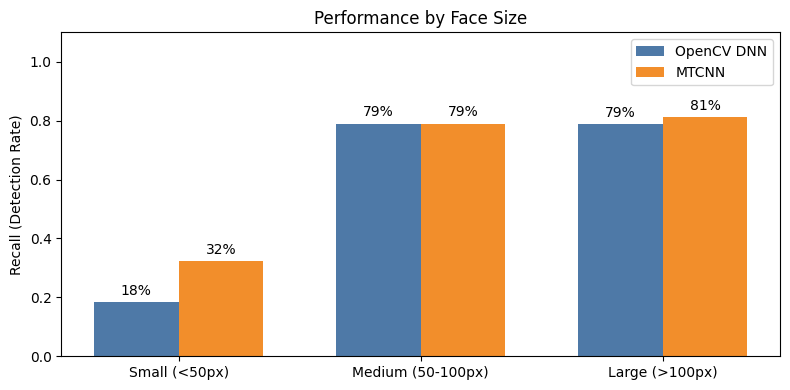

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
rects1 = ax.bar(x - width/2, recall_dnn, width, label='OpenCV DNN', color='#4E79A7')
rects2 = ax.bar(x + width/2, recall_mtcnn, width, label='MTCNN', color='#F28E2B')

ax.set_ylabel('Recall (Detection Rate)')
ax.set_title('Performance by Face Size')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 1.1)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()

rostros mas grandes son mas detectables, 

In [ ]:

# analisis de alturas de rostros
all_heights = []

print("Analizando distribución del dataset...")
for img_path, boxes in ground_truth.items():
    for box in boxes:
        # box = [x, y, w, h] -> nos interesa el índice 3 (h)
        h = box[3]
        all_heights.append(h)

print(f"Total de rostros analizados: {len(all_heights)}")
print(f"Altura mínima: {min(all_heights)} px")
print(f"Altura máxima: {max(all_heights)} px")
print(f"Altura promedio: {np.mean(all_heights):.2f} px")
print(f"Mediana de altura: {np.median(all_heights):.2f} px")

plt.figure(figsize=(8, 4))

# bins cada 20 pixeles 
# Limitamos el rango a 400px 
max_range = 400 
bins = range(0, max_range + 20, 20) 

# histograma de distribucion de rostros
n, bins, patches = plt.hist(all_heights, bins=bins, color='#6baed6', edgecolor='black', alpha=0.7)

plt.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Límite Small (<50px)')
plt.axvline(x=100, color='orange', linestyle='--', linewidth=2, label='Límite Medium (50-100px)')


plt.title('Distribución de Frecuencia del Tamaño de Rostros (WIDER FACE Val)', fontsize=14)
plt.xlabel('Altura del Rostro (Píxeles)', fontsize=12)
plt.ylabel('Cantidad de Rostros', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# calculates te amounts of each category
total = len(all_heights)
small = sum(h < 50 for h in all_heights)
medium = sum(50 <= h < 100 for h in all_heights)
large = sum(h >= 100 for h in all_heights) # Incluye los mayores a 400 que no salen en el plot

plt.text(25, max(n)*0.8, f"SMALL\n{small/total:.1%}", ha='center', color='red', fontweight='bold')
plt.text(75, max(n)*0.4, f"MEDIUM\n{medium/total:.1%}", ha='center', color='orange', fontweight='bold')
plt.text(150, max(n)*0.2, f"LARGE\n{large/total:.1%}", ha='center', color='green', fontweight='bold')

plt.xlim(0, max_range)
plt.tight_layout()
plt.show()

### Face size distribution

In [29]:
# --- CONFIGURACIÓN ---
BIN_WIDTH = 20          # Ancho del bin en píxeles (0-20, 20-40...)
MAX_SIZE_PLOT = 300     
CONF_THRESH_DNN = 0.5
CONF_THRESH_MTCNN = 0.8 
IOU_THRESH = 0.4

# raw values: (Altura, Fue_Detectado_DNN, Fue_Detectado_MTCNN)
raw_data = []

print("Recopilando datos de tamaño y detección...")

# Función auxiliar de IoU (versión optimizada)
def get_max_iou(boxA, boxesB):
    if len(boxesB) == 0: return 0
    boxesB = np.array(boxesB)
    xA = np.maximum(boxA[0], boxesB[:, 0])
    yA = np.maximum(boxA[1], boxesB[:, 1])
    xB = np.minimum(boxA[2], boxesB[:, 2])
    yB = np.minimum(boxA[3], boxesB[:, 3])
    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxesB[:, 2] - boxesB[:, 0] + 1) * (boxesB[:, 3] - boxesB[:, 1] + 1)
    ious = interArea / (boxAArea + boxBArea - interArea)
    return np.max(ious)

count = 0
limit = 100 # Usa None para procesar todo el dataset, o 100-200 para una muestra rápida

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Analizando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_img, w_img = img_bgr.shape[:2]
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 1. Obtener Predicciones DNN
    blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_img, h_img), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    det_dnn = net.forward()
    preds_dnn = []
    for i in range(det_dnn.shape[2]):
        if det_dnn[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_dnn[0, 0, i, 3:7] * np.array([w_img, h_img, w_img, h_img])
            preds_dnn.append(box.astype("int"))

    # 2. Obtener Predicciones MTCNN
    res_mtcnn = detector_mtcnn.detect_faces(img_rgb)
    preds_mtcnn = []
    for face in res_mtcnn:
        if face['confidence'] > CONF_THRESH_MTCNN:
            x, y, w, h = face['box']
            preds_mtcnn.append([x, y, x+w, y+h])

    # 3. Evaluar cada Ground Truth individualmente
    for box in true_boxes_raw:
        gt_x, gt_y, gt_w, gt_h = box
        gt_box_fmt = [gt_x, gt_y, gt_x + gt_w, gt_y + gt_h]
        
        # Verificar si DNN lo vio
        iou_dnn = get_max_iou(gt_box_fmt, preds_dnn)
        detected_dnn = iou_dnn >= IOU_THRESH
        
        # Verificar si MTCNN lo vio
        iou_mtcnn = get_max_iou(gt_box_fmt, preds_mtcnn)
        detected_mtcnn = iou_mtcnn >= IOU_THRESH
        
        # Guardamos: (Altura en px, Bool DNN, Bool MTCNN)
        raw_data.append((gt_h, detected_dnn, detected_mtcnn))

print(f"Análisis completado. Total de caras evaluadas: {len(raw_data)}")

Recopilando datos de tamaño y detección...
Analizando imagen 20...
Analizando imagen 40...
Analizando imagen 60...
Analizando imagen 80...
Analizando imagen 100...
Análisis completado. Total de caras evaluadas: 1631


In [31]:
# bins
bins = np.arange(0, MAX_SIZE_PLOT + BIN_WIDTH, BIN_WIDTH)
bin_centers = bins[:-1] + BIN_WIDTH / 2

# 
hist_counts = []     # count per range
recall_dnn = []      # detection rate DNN
recall_mtcnn = []    # detection rate MTCNN

for i in range(len(bins) - 1):
    min_s = bins[i]
    max_s = bins[i+1]
    
    # filter by bin
    faces_in_bin = [d for d in raw_data if min_s <= d[0] < max_s]
    total = len(faces_in_bin)
    
    hist_counts.append(total)
    
    if total > 0:
        # Sumar True (1) y False (0)
        tp_dnn = sum([d[1] for d in faces_in_bin])
        tp_mtcnn = sum([d[2] for d in faces_in_bin])
        
        recall_dnn.append(tp_dnn / total)
        recall_mtcnn.append(tp_mtcnn / total)
    else:
        recall_dnn.append(0)
        recall_mtcnn.append(0)

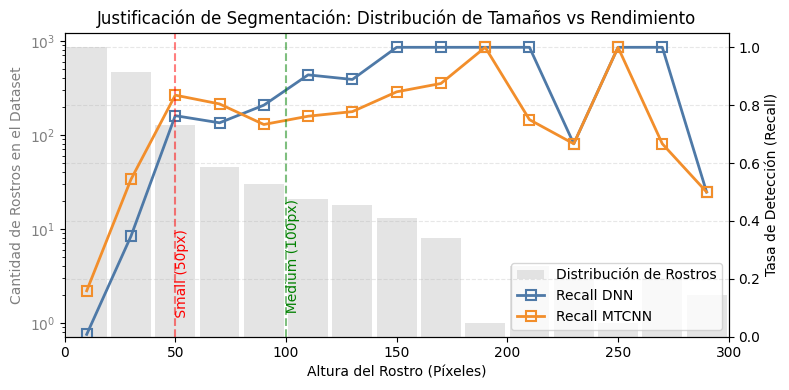

In [32]:
fig, ax1 = plt.subplots(figsize=(8, 4))

color_bar = 'lightgray'
ax1.set_xlabel('Altura del Rostro (Píxeles)')
ax1.set_ylabel('Cantidad de Rostros en el Dataset', color='gray')
bars = ax1.bar(bin_centers, hist_counts, width=BIN_WIDTH*0.9, color=color_bar, alpha=0.6, label='Distribución de Rostros')
ax1.tick_params(axis='y', labelcolor='gray')
ax1.set_yscale("log")
# Eje Derecho (Curvas de Recall)
ax2 = ax1.twinx()  # Instanciar un segundo eje que comparte el mismo eje x
ax2.set_ylabel('Tasa de Detección (Recall)', color='black')

# Graficar líneas
line1, = ax2.plot(bin_centers, recall_dnn, color='#4E79A7', marker='s', markersize=7, mfc="none",  \
                  mec ='#4E79A7',mew=1.5, linewidth=2, label='Recall DNN')
line2, = ax2.plot(bin_centers, recall_mtcnn, color='#F28E2B', marker='s', markersize=7, mfc="none",\
                  mec='#F28E2B',mew=1.5, linewidth=2, label='Recall MTCNN')

# segmentation (Small/Medium/Large)
plt.axvline(x=50, color='red', linestyle='--', alpha=0.5)
plt.axvline(x=100, color='green', linestyle='--', alpha=0.5)


ax2.text(50, 0.05, ' Small (50px)', color='red', rotation=90, verticalalignment='bottom')
ax2.text(100, 0.05, '  Medium (100px)', color='green', rotation=90, verticalalignment='bottom')

ax2.set_ylim(0, 1.05)
ax2.set_xlim(0, MAX_SIZE_PLOT)

lines = [bars, line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right') #'upper center')

plt.title('Justificación de Segmentación: Distribución de Tamaños vs Rendimiento')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Examples/Category

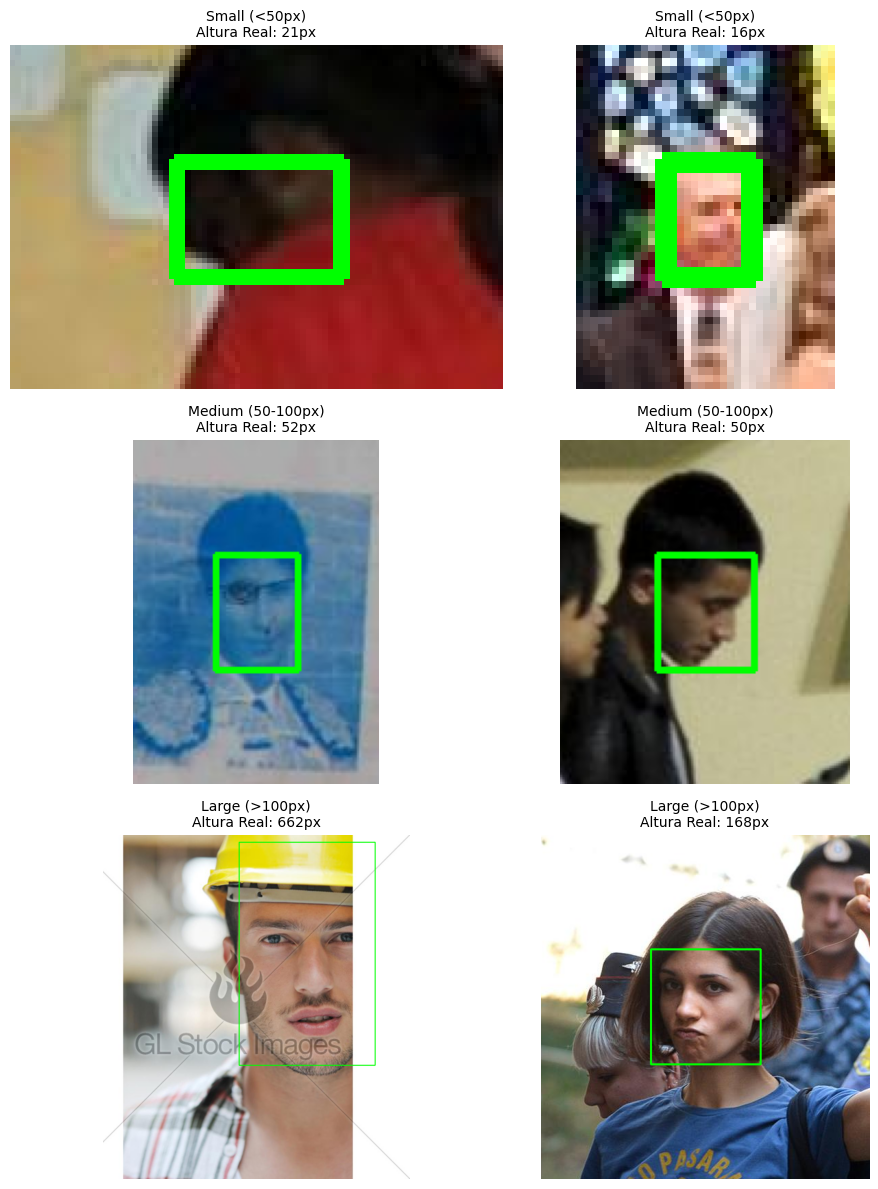

In [33]:
# representative examples/ images for each categiry
RANGES = {
    'Small (<50px)': (0, 50),
    'Medium (50-100px)': (50, 100),
    'Large (>100px)': (100, 9999)
}

# 'Category': [ (path_img1, box), (path_img2, box) ]
examples_found = {k: [] for k in RANGES.keys()}

def get_category_name(h):
    for name, (min_h, max_h) in RANGES.items():
        if min_h <= h < max_h:
            return name
    return None


collected = 0
needed=6
for img_path_rel, boxes in ground_truth.items():
    if collected >= needed: break # Ya tenemos todo
    
    for box in boxes:
        x, y, w, h = box
        cat = get_category_name(h)
        
        if cat and len(examples_found[cat]) < 2:
            examples_found[cat].append((img_path_rel, box))
            collected += 1
            break 


fig, axes = plt.subplots(3, 2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.4)

ordered_cats = ['Small (<50px)', 'Medium (50-100px)', 'Large (>100px)']

for row_idx, cat_name in enumerate(ordered_cats):
    samples = examples_found[cat_name]
    
    for col_idx, (img_path, box) in enumerate(samples):
        full_path = os.path.join(val_images, img_path)
        img = cv2.imread(full_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img, _ = img.shape
        x, y, w, h = box
        
        # face box
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # zoom in
        # to easily see the face
        pad_x = w
        pad_y = h
        
        # Coordenadas de recorte asegurando no salirnos de la imagen
        crop_x1 = max(0, x - pad_x)
        crop_y1 = max(0, y - pad_y)
        crop_x2 = min(w_img, x + w + pad_x)
        crop_y2 = min(h_img, y + h + pad_y)
        
        cropped_img = img[crop_y1:crop_y2, crop_x1:crop_x2]
        
        # Mostrar en el subplot correspondiente
        ax = axes[row_idx, col_idx]
        ax.imshow(cropped_img)
        ax.set_title(f"{cat_name}\nAltura Real: {h}px", fontsize=10)
        ax.axis('off')


#fig.suptitle("Comparativa Visual por Tamaño de Rostro (Ground Truth)\n(Recortes con Zoom)", fontsize=16)
plt.tight_layout()
plt.show()

## Pre-processing

In [39]:
# gamma and sharpenning
CONF_THRESH_DNN   = 0.4   # Bajamos un poco para captar más caras difíciles (luego filtramos)
CONF_THRESH_MTCNN = 0.8 
IOU_THRESH        = 0.4
TARGET_SIZE_DNN   = (1024, 1024) # force to ingrease the img size

# --- light correction
def preprocess_image(img_bgr):
    # gamma correction
    gamma = 1.5 # for values greater than 1 -> makes img clearer
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img_gamma = cv2.LUT(img_bgr, table)
    
    # Sharpening to enhace borders
    kernel = np.array([[0, -1, 0], 
                       [-1, 5,-1], 
                       [0, -1, 0]])
    img_sharp = cv2.filter2D(img_gamma, -1, kernel)
    
    return img_sharp


stats_improved = {
    'DNN_Base':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}, # Para comparar
    'DNN_Mejorado': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

print("comparative")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Preparamos Ground Truth
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # =======================================================
    # 1. DNN BASE (Como lo tenías antes, para control)
    # =======================================================
    # Usaba tamaño original
    blob_base = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_base)
    det_base = net.forward()
    
    preds_base = []
    for i in range(det_base.shape[2]):
        if det_base[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_base[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_base.append(box.astype("int"))
            
    # =======================================================
    # 2. DNN MEJORADO (Gamma + High-Res Blob)
    # =======================================================
    
    # A. Aplicar mejora de luz
    img_opt = preprocess_image(img_bgr)
    
    # B. Upsampling en el Blob (Aquí ocurre la magia del tamaño)
    # Usamos TARGET_SIZE_DNN (1024x1024)
    # Nota: SSD redimensiona internamente, pero al darle un target grande, no pierde detalles.
    blob_opt = cv2.dnn.blobFromImage(img_opt, 1.0, TARGET_SIZE_DNN, (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_opt)
    det_opt = net.forward()
    
    preds_opt = []
    for i in range(det_opt.shape[2]):
        confidence = det_opt[0, 0, i, 2]
        if confidence > CONF_THRESH_DNN:
            # IMPORTANTE: OpenCV devuelve coordenadas normalizadas (0 a 1).
            # Al multiplicar por (w_orig, h_orig), automáticamente mapeamos 
            # de vuelta a la imagen original, sin importar que el blob fuera 1024x1024.
            box = det_opt[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_opt.append(box.astype("int"))

    # ==========================
    # EVALUACIÓN
    # ==========================
    evaluate_model_by_size('DNN_Base', preds_base, gt_boxes, gt_heights, stats_improved) 
    evaluate_model_by_size('DNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_improved)

# ... (Código de impresión de gráficas similar al anterior) ...

# IMPRIMIR TABLA COMPARATIVA TEXTO
print("\n--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_improved['DNN_Base'][cat]['TP']
    total = tp + stats_improved['DNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_improved['DNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_improved['DNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")



# gamma and sharpenning with lower thresholds and imgsize fixed
CONF_THRESH_DNN     = 0.4   # Bajamos un poco para captar más caras difíciles 
CONF_THRESH_MTCNN   = 0.8 
IOU_THRESH          = 0.4
TARGET_SIZE_DNN     = (1024, 1024) # force to ingrease the img size
CONF_THRESH_STRICT  = 0.5  # Para medición estándar
CONF_THRESH_LENIENT = 0.3 # <--- CAMBIO 1: Ser más permisivo con caras difíciles
SCALE_FACTOR        = 2.0

# --- light correction
def preprocess_image(img_bgr):
    # gamma correction
    gamma = 1.5 # for values greater than 1 -> makes img clearer
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img_gamma = cv2.LUT(img_bgr, table)
    
    # Sharpening to enhace borders
    kernel = np.array([[0, -1, 0], 
                       [-1, 5,-1], 
                       [0, -1, 0]])
    img_sharp = cv2.filter2D(img_gamma, -1, kernel)
    
    return img_sharp


stats_improved = {
    'DNN_Base':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}, # Para comparar
    'DNN_Mejorado': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

print("comparative")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Preparamos Ground Truth
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # =======================================================
    # DNN BASE 
    # =======================================================
    # Usaba tamaño original
    blob_base = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_base)
    det_base = net.forward()
    
    preds_base = []
    for i in range(det_base.shape[2]):
        if det_base[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_base[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_base.append(box.astype("int"))
            
    # =======================================================
    # NN MEJORADO v2
    # =======================================================
    max_dim = max(w_orig, h_orig)
    if max_dim < 1200:
        scale = SCALE_FACTOR # x2.0
    else:
        scale = 1.0 # Dejar igual si ya es gigante
        
    new_w = int(w_orig * scale)
    new_h = int(h_orig * scale)
    
    # B. Aplicar preprocesamiento de luz (Gamma) - Mantenemos esto
    img_opt = preprocess_image(img_bgr) # Tu función gamma anterior
    
    # C. Crear Blob con tamaño dinámico proporcional
    blob_opt = cv2.dnn.blobFromImage(img_opt, 1.0, (new_w, new_h), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_opt)
    det_opt = net.forward()
    
    preds_opt = []
    for i in range(det_opt.shape[2]):
        confidence = det_opt[0, 0, i, 2]
        
        # Usamos el umbral más bajo (0.3) para captar lo que antes perdíamos
        if confidence > CONF_THRESH_LENIENT:
            # OpenCV maneja el re-escalado de coords automáticamente
            box = det_opt[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_opt.append(box.astype("int"))

    # ==========================
    # EVALUACIÓN
    # ==========================
    evaluate_model_by_size('DNN_Base', preds_base, gt_boxes, gt_heights, stats_improved) 
    evaluate_model_by_size('DNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_improved)



# IMPRIMIR TABLA COMPARATIVA TEXTO
print("\n--- COMPARATIVA DE RECALL GAMMA & SHARP ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_improved['DNN_Base'][cat]['TP']
    total = tp + stats_improved['DNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_improved['DNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_improved['DNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")

# lower thresholds and multiscale
CONF_THRESH_LOW = 0.3    
NMS_THRESH = 0.4         

def detectar_multiescala(net, img_bgr):
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Listas para acumular todas las detecciones de ambas escalas
    rects_totales = []
    confidencias_totales = []
    
    # ---------------------------------------------------------
    # ESCALA 1: ORIGINAL (Para caras Grandes y Medianas)
    # ---------------------------------------------------------
    # Usamos tamaño original (o limitado si es 4K para no explotar)
    blob1 = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob1)
    det1 = net.forward()
    
    for i in range(det1.shape[2]):
        conf = det1[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            box = det1[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            rects_totales.append(box.astype("int"))
            confidencias_totales.append(float(conf))

    # Upscalibng
    # Aplicamos Gamma antes de escalar 
    img_proc = preprocess_image(img_bgr) 
    
    # x 1.8
    scale_factor = 1.8
    new_w, new_h = int(w_orig * scale_factor), int(h_orig * scale_factor)
    
    blob2 = cv2.dnn.blobFromImage(img_proc, 1.0, (new_w, new_h), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob2)
    det2 = net.forward()
    
    for i in range(det2.shape[2]):
        conf = det2[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            # Importante: Des-escalar las coordenadas para que coincidan con la original
            box = det2[0, 0, i, 3:7] * np.array([new_w, new_h, new_w, new_h])
            box = box / scale_factor # Volver a coordenadas originales
            rects_totales.append(box.astype("int"))
            confidencias_totales.append(float(conf))

    # Non-maximum supression
    if len(rects_totales) > 0:
        # Convertir a formato [x, y, w, h] que requiere NMSBoxes
        boxes_nms = []
        for (x1, y1, x2, y2) in rects_totales:
            boxes_nms.append([x1, y1, x2 - x1, y2 - y1]) # x, y, ancho, alto
        
        # Aplicar NMS, return indexes of outstanding boxwes
        indices = cv2.dnn.NMSBoxes(boxes_nms, confidencias_totales, CONF_THRESH_LOW, NMS_THRESH)
        
        final_boxes = []
        if len(indices) > 0:
            for i in indices.flatten():
                x, y, w, h = boxes_nms[i]
                final_boxes.append([x, y, x+w, y+h]) # Regresamos a x2, y2 para tu evaluador
        
        return final_boxes
    else:
        return []

def preprocess_image(img_bgr):
    # gamma correction
    gamma = 1.5 # for values greater than 1 -> makes img clearer
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img_gamma = cv2.LUT(img_bgr, table)
    
    # Sharpening to enhace borders
    kernel = np.array([[0, -1, 0], 
                       [-1, 5,-1], 
                       [0, -1, 0]])
    img_sharp = cv2.filter2D(img_gamma, -1, kernel)
    
    return img_sharp


stats_improved = {
    'DNN_Base':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}, # Para comparar
    'DNN_Mejorado': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

print("comparative")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Preparamos Ground Truth
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # =======================================================
    # 1. DNN BASE 
    # =======================================================
    # Usaba tamaño original
    blob_base = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_base)
    det_base = net.forward()
    
    preds_base = []
    for i in range(det_base.shape[2]):
        if det_base[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_base[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_base.append(box.astype("int"))
            



    # 2. DNN MEJORADO (Multi-Escala)

    preds_opt = detectar_multiescala(net, img_bgr)

    # Evaluación
    evaluate_model_by_size('DNN_Base', preds_base, gt_boxes, gt_heights, stats_improved)
    evaluate_model_by_size('DNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_improved)


# IMPRIMIR TABLA COMPARATIVA TEXTO
print("\n--- COMPARATIVA DE RECALL MultiEscala ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_improved['DNN_Base'][cat]['TP']
    total = tp + stats_improved['DNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_improved['DNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_improved['DNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")

comparative
Procesando imagen 20...
Procesando imagen 40...
Procesando imagen 60...
Procesando imagen 80...
Procesando imagen 100...

--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---
Cat Small (<50px): 18.5% -> 19.0% (Mejora: +0.5%)
Cat Medium (50-100px): 79.0% -> 75.0% (Mejora: +-4.0%)
Cat Large (>100px): 78.9% -> 77.8% (Mejora: +-1.1%)
comparative
Procesando imagen 20...
Procesando imagen 40...
Procesando imagen 60...
Procesando imagen 80...
Procesando imagen 100...

--- COMPARATIVA DE RECALL GAMMA & SHARP ---
Cat Small (<50px): 18.5% -> 27.6% (Mejora: +9.1%)
Cat Medium (50-100px): 79.0% -> 75.8% (Mejora: +-3.2%)
Cat Large (>100px): 78.9% -> 58.9% (Mejora: +-20.0%)
comparative
Procesando imagen 20...
Procesando imagen 40...
Procesando imagen 60...
Procesando imagen 80...
Procesando imagen 100...

--- COMPARATIVA DE RECALL MultiEscala ---
Cat Small (<50px): 18.5% -> 30.1% (Mejora: +11.6%)
Cat Medium (50-100px): 79.0% -> 84.7% (Mejora: +5.6%)
Cat Large (>100px): 78.9% -> 81.1% 

Buscando una imagen compleja para la demostración...
Imagen seleccionada: 17--Ceremony/17_Ceremony_Ceremony_17_944.jpg (17 caras reales)


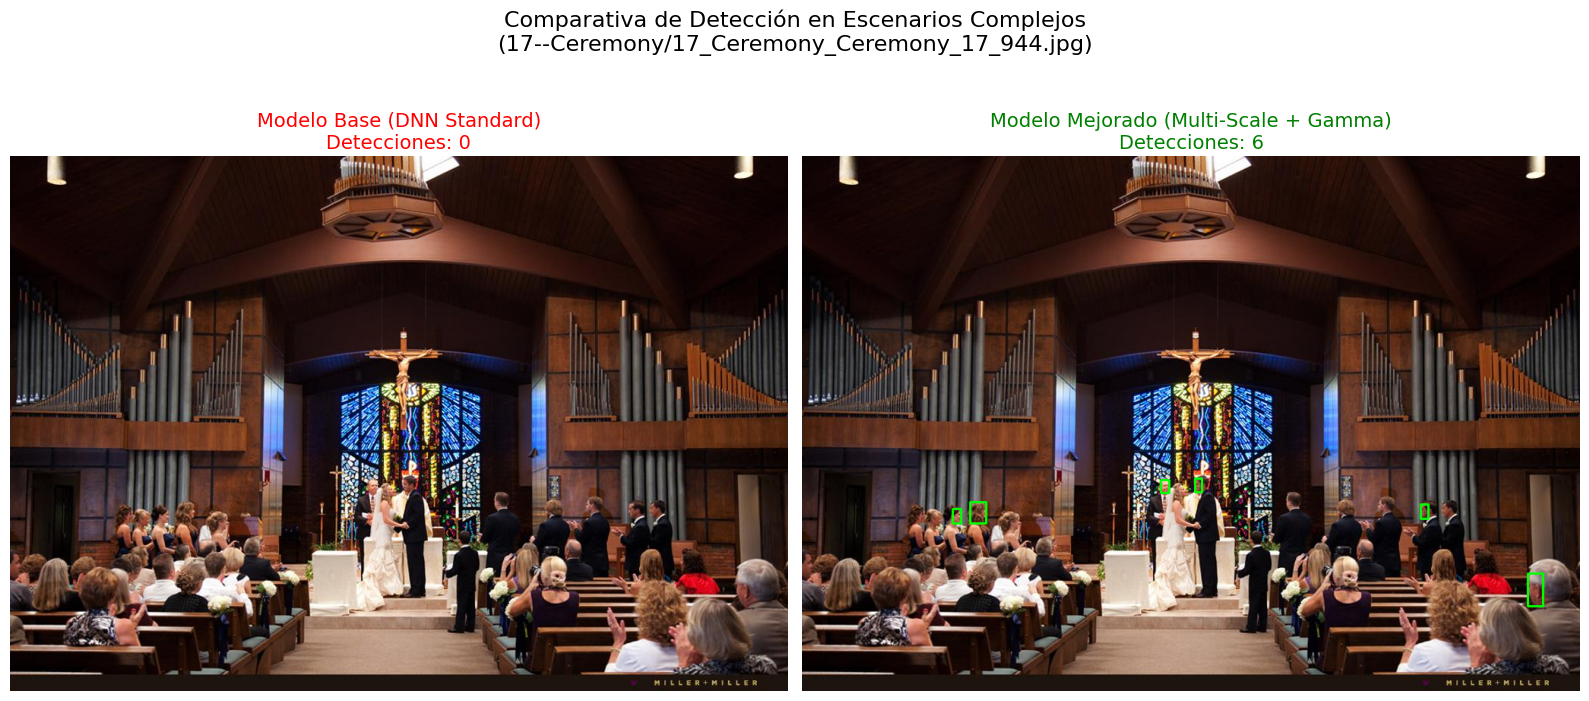

In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def dibujar_cajas(img, boxes, color=(0, 255, 0), thickness=2):
    img_copy = img.copy()
    for (x1, y1, x2, y2) in boxes:
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, thickness)
    return img_copy

# --- BUSCAR UNA IMAGEN "DIFÍCIL" (con muchas caras) ---
print("Buscando una imagen compleja para la demostración...")
target_img_path = None
gt_count = 0

# Buscamos una imagen que tenga entre 10 y 50 caras para que se note la diferencia
for img_path_rel, boxes in ground_truth.items():
    if 15 < len(boxes) < 100: 
        target_img_path = img_path_rel
        gt_count = len(boxes)
        break

if target_img_path:
    full_path = os.path.join(val_images, target_img_path)
    img_bgr = cv2.imread(full_path)
    h_orig, w_orig = img_bgr.shape[:2]
    print(f"Imagen seleccionada: {target_img_path} ({gt_count} caras reales)")

    # ---------------------------------------------
    # 1. MODELO BASE (Standard)
    # ---------------------------------------------
    blob_base = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_base)
    det_base = net.forward()
    
    preds_base = []
    for i in range(det_base.shape[2]):
        if det_base[0, 0, i, 2] > 0.5: # Umbral estricto original
            box = det_base[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_base.append(box.astype("int"))

    # ---------------------------------------------
    # 2. MODELO MEJORADO (Multi-Escala + NMS)
    # ---------------------------------------------
    # Usamos la función que creamos antes
    preds_improved = detectar_multiescala(net, img_bgr)


    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Dibujar resultados
    res_base = dibujar_cajas(img_rgb, preds_base, color=(255, 0, 0), thickness=2)      # ROJO = Base
    res_imp = dibujar_cajas(img_rgb, preds_improved, color=(0, 255, 0), thickness=2)   # VERDE = Mejorado

    # Crear figura
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot Base
    axes[0].imshow(res_base)
    axes[0].set_title(f"Modelo Base (DNN Standard)\nDetecciones: {len(preds_base)}", fontsize=14, color='red')
    axes[0].axis('off')
    
    # Plot Mejorado
    axes[1].imshow(res_imp)
    axes[1].set_title(f"Modelo Mejorado (Multi-Scale + Gamma)\nDetecciones: {len(preds_improved)}", fontsize=14, color='green')
    axes[1].axis('off')

    plt.suptitle(f"Comparativa de Detección en Escenarios Complejos\n({target_img_path})", fontsize=16)
    plt.tight_layout()
    plt.show()

else:
    print("No se encontró una imagen adecuada en el rango solicitado.")

In [41]:
# tiling and CLAHGE

# Umbrales
CONF_THRESH_LOW = 0.3     
NMS_THRESH = 0.4          

def preprocess_clahe(img_bgr):
    # to LAB -> light L
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # apply CLAHE the channedl L
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    limg = cv2.merge((cl, a, b))
    img_clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return img_clahe

def detect_with_tiling(net, img_bgr):
    h_orig, w_orig = img_bgr.shape[:2]
    
    rects_totales = []
    confidencias_totales = []
    
    # =========================================================
    # full face
    # =========================================================

    blob1 = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob1)
    det1 = net.forward()
    
    for i in range(det1.shape[2]):
        conf = det1[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            box = det1[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            rects_totales.append(box.astype("int"))
            confidencias_totales.append(float(conf))
            
    # =========================================================
    #  TILING small faces
    # =========================================================
    
    
    img_proc = preprocess_clahe(img_bgr)
    
    # Definir filas y columnas para el tiling (2x2 suele ser suficiente y rápido)
    rows, cols = 2, 2
    
    # Calculamos tamaño del tile
    tile_h = int(h_orig / 1.5) # Hacemos tiles grandes
    tile_w = int(w_orig / 1.5) # con mucha superposición
    
    # Pasos (stride) para mover la ventana
    step_h = (h_orig - tile_h) // (rows - 1) if rows > 1 else 0
    step_w = (w_orig - tile_w) // (cols - 1) if cols > 1 else 0
    
    if rows == 1: step_h = 0
    if cols == 1: step_w = 0

    # Recorremos los tiles
    for r in range(rows):
        for c in range(cols):
            # Coordenadas del recorte
            y1 = r * step_h
            x1 = c * step_w
            y2 = y1 + tile_h
            x2 = x1 + tile_w
            
            # Recortar (Crop)
            tile = img_proc[y1:y2, x1:x2]
            
            # --- Inferencia en el Tile ---
            # Nota: Al pasar un tile más pequeño al blob de tamaño fijo o relativo,
            # la red ve los objetos "más grandes".
            blob_tile = cv2.dnn.blobFromImage(tile, 1.0, (tile_w, tile_h), (104.0, 117.0, 123.0), False, False)
            net.setInput(blob_tile)
            det_tile = net.forward()
            
            for i in range(det_tile.shape[2]):
                conf = det_tile[0, 0, i, 2]
                if conf > CONF_THRESH_LOW:
                    # Obtener coords relativas al tile
                    box_local = det_tile[0, 0, i, 3:7] * np.array([tile_w, tile_h, tile_w, tile_h])
                    
                    # TRANSFORMACIÓN CLAVE: + offset (x1, y1) para volver a coordenadas globales
                    global_x1 = int(box_local[0] + x1)
                    global_y1 = int(box_local[1] + y1)
                    global_x2 = int(box_local[2] + x1)
                    global_y2 = int(box_local[3] + y1)
                    
                    # Validar límites
                    global_x1 = max(0, global_x1)
                    global_y1 = max(0, global_y1)
                    global_x2 = min(w_orig, global_x2)
                    global_y2 = min(h_orig, global_y2)
                    
                    rects_totales.append([global_x1, global_y1, global_x2, global_y2])
                    confidencias_totales.append(float(conf))

    # ==========================
    # NON-MAXIMUM SUPPRESSION 
    # ==========================
    if len(rects_totales) > 0:
        boxes_nms = []
        for (x_min, y_min, x_max, y_max) in rects_totales:
            boxes_nms.append([x_min, y_min, x_max - x_min, y_max - y_min]) # x, y, w, h
        
        # Unificamos detecciones del Paso 1 y Paso 2
        indices = cv2.dnn.NMSBoxes(boxes_nms, confidencias_totales, CONF_THRESH_LOW, NMS_THRESH)
        
        final_boxes = []
        if len(indices) > 0:
            for i in indices.flatten():
                x, y, w, h = boxes_nms[i]
                final_boxes.append([x, y, x+w, y+h])
        
        return final_boxes
    else:
        return []

# lower thresholds
CONF_THRESH_LOW = 0.3    
NMS_THRESH = 0.4         



stats_improved = {
    'DNN_Base':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}, # Para comparar
    'DNN_Mejorado': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

print("comparative")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Preparamos Ground Truth
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # =======================================================
    # 1. DNN BASE (Como lo tenías antes, para control)
    # =======================================================
    # Usaba tamaño original
    blob_base = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_base)
    det_base = net.forward()
    
    preds_base = []
    for i in range(det_base.shape[2]):
        if det_base[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_base[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_base.append(box.astype("int"))
            



    # 2. DNN MEJORADO (Multi-Escala)

    #preds_opt = detectar_multiescala(net, img_bgr)
    preds_opt = detect_with_tiling(net, img_bgr)

    # Evaluación
    evaluate_model_by_size('DNN_Base', preds_base, gt_boxes, gt_heights, stats_improved)
    evaluate_model_by_size('DNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_improved)


# IMPRIMIR TABLA COMPARATIVA TEXTO
print("\n--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_improved['DNN_Base'][cat]['TP']
    total = tp + stats_improved['DNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_improved['DNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_improved['DNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")



# HYBRID
CONF_THRESH_LOW = 0.25  # Bajamos un poco más para captar lo muy difícil (luego NMS filtra)
NMS_THRESH = 0.4 
TILE_SCALE_FACTOR = 2.2 # El "Zoom" que aplicaremos a cada recorte

def preprocess_clahe(img_bgr):
    """ Mantenemos CLAHE porque ayudó mucho en los rangos medios/grandes """
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)) # Ligeramente más fuerte
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def detect_hybrid_zoom(net, img_bgr):
    h_orig, w_orig = img_bgr.shape[:2]
    
    rects_totales = []
    confidencias_totales = []
    
    # ---------------------------------------------------------
    # 1. PASE GLOBAL (1.0x) - Detecta Grande/Mediano
    # ---------------------------------------------------------
    # Usamos la imagen original tal cual (o con CLAHE leve si prefieres)
    blob_global = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_global)
    det_global = net.forward()
    
    for i in range(det_global.shape[2]):
        conf = det_global[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            box = det_global[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            rects_totales.append(box.astype("int"))
            confidencias_totales.append(float(conf))

    # ---------------------------------------------------------
    # 2. PASE "ZOOMED TILES" - Detecta Pequeño/Tiny
    # ---------------------------------------------------------
    # Preprocesamos para resaltar detalles en zonas oscuras
    img_clahe = preprocess_clahe(img_bgr)
    
    # Configuración de grilla (2x2 suele ser ideal para balancear velocidad/detalle)
    rows, cols = 2, 2
    
    # Tamaño del recorte base (con superposición para no cortar caras en bordes)
    # Hacemos tiles que cubran el 60% de la dimensión (generando overlap del 20%)
    tile_h_orig = int(h_orig * 0.60)
    tile_w_orig = int(w_orig * 0.60)
    
    # Stride (paso)
    step_h = int((h_orig - tile_h_orig) / (rows - 1)) if rows > 1 else 0
    step_w = int((w_orig - tile_w_orig) / (cols - 1)) if cols > 1 else 0

    for r in range(rows):
        for c in range(cols):
            # Coordenadas de recorte
            y1 = r * step_h
            x1 = c * step_w
            y2 = y1 + tile_h_orig
            x2 = x1 + tile_w_orig
            
            # Recorte seguro
            tile = img_clahe[y1:y2, x1:x2]
            
            # --- EL TRUCO: ZOOM (UPSCALING) AL TILE ---
            # Si el tile mide 500x500, lo estiramos a 1100x1100 (x2.2)
            # Esto hace que una cara de 20px se vuelva de 44px (detectable)
            # sin tener que escalar toda la imagen 4K original.
            
            zoom_w = int(tile.shape[1] * TILE_SCALE_FACTOR)
            zoom_h = int(tile.shape[0] * TILE_SCALE_FACTOR)
            
            # Blob usando el tamaño "zoomed"
            # Nota: No necesitamos hacer cv2.resize explícito, blobFromImage lo hace si damos size
            blob_tile = cv2.dnn.blobFromImage(tile, 1.0, (zoom_w, zoom_h), (104.0, 117.0, 123.0), False, False)
            
            net.setInput(blob_tile)
            det_tile = net.forward()
            
            for i in range(det_tile.shape[2]):
                conf = det_tile[0, 0, i, 2]
                if conf > CONF_THRESH_LOW:
                    # Las coordenadas vienen relativas al tamaño ZOOMED (zoom_w, zoom_h)
                    box_local = det_tile[0, 0, i, 3:7] * np.array([zoom_w, zoom_h, zoom_w, zoom_h])
                    
                    # 1. Des-escalar el Zoom (volver al tamaño del tile original)
                    box_local = box_local / TILE_SCALE_FACTOR
                    
                    # 2. Sumar el offset del tile (volver a coordenadas globales)
                    global_x1 = int(box_local[0] + x1)
                    global_y1 = int(box_local[1] + y1)
                    global_x2 = int(box_local[2] + x1)
                    global_y2 = int(box_local[3] + y1)
                    
                    # Validación de bordes
                    rects_totales.append([
                        max(0, global_x1), 
                        max(0, global_y1), 
                        min(w_orig, global_x2), 
                        min(h_orig, global_y2)
                    ])
                    confidencias_totales.append(float(conf))

    # ---------------------------------------------------------
    # 3. NON-MAXIMUM SUPPRESSION FINAL
    # ---------------------------------------------------------
    if len(rects_totales) > 0:
        boxes_nms = []
        for (x1, y1, x2, y2) in rects_totales:
            boxes_nms.append([x1, y1, x2 - x1, y2 - y1]) # x, y, w, h
        
        indices = cv2.dnn.NMSBoxes(boxes_nms, confidencias_totales, CONF_THRESH_LOW, NMS_THRESH)
        
        final_boxes = []
        if len(indices) > 0:
            for i in indices.flatten():
                x, y, w, h = boxes_nms[i]
                final_boxes.append([x, y, x+w, y+h])
        return final_boxes
    else:
        return []

comparative
Procesando imagen 20...
Procesando imagen 40...
Procesando imagen 60...
Procesando imagen 80...
Procesando imagen 100...

--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---
Cat Small (<50px): 18.5% -> 24.5% (Mejora: +6.0%)
Cat Medium (50-100px): 79.0% -> 81.5% (Mejora: +2.4%)
Cat Large (>100px): 78.9% -> 86.7% (Mejora: +7.8%)


In [42]:


# lower thresholds
CONF_THRESH_LOW = 0.3    
NMS_THRESH = 0.4         



stats_improved = {
    'DNN_Base':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}, # Para comparar
    'DNN_Mejorado': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

print("comparative")

count = 0
limit = 100 

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 20 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    
    # Preparamos Ground Truth
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # =======================================================
    # 1. DNN BASE (Como lo tenías antes, para control)
    # =======================================================
    # Usaba tamaño original
    blob_base = cv2.dnn.blobFromImage(img_bgr, 1.0, (w_orig, h_orig), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob_base)
    det_base = net.forward()
    
    preds_base = []
    for i in range(det_base.shape[2]):
        if det_base[0, 0, i, 2] > CONF_THRESH_DNN:
            box = det_base[0, 0, i, 3:7] * np.array([w_orig, h_orig, w_orig, h_orig])
            preds_base.append(box.astype("int"))
            



    # 2. DNN MEJORADO (Multi-Escala)

    #preds_opt = detectar_multiescala(net, img_bgr)
    preds_opt = detect_hybrid_zoom(net, img_bgr)

    # Evaluación
    evaluate_model_by_size('DNN_Base', preds_base, gt_boxes, gt_heights, stats_improved)
    evaluate_model_by_size('DNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_improved)



print("\n--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_improved['DNN_Base'][cat]['TP']
    total = tp + stats_improved['DNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_improved['DNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_improved['DNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")

comparative
Procesando imagen 20...
Procesando imagen 40...
Procesando imagen 60...
Procesando imagen 80...
Procesando imagen 100...

--- COMPARATIVA DE RECALL (DNN Base vs DNN Mejorado) ---
Cat Small (<50px): 18.5% -> 38.2% (Mejora: +19.7%)
Cat Medium (50-100px): 79.0% -> 87.1% (Mejora: +8.1%)
Cat Large (>100px): 78.9% -> 63.3% (Mejora: +-15.6%)


### Overall Benchmark

In [60]:
print("--------------- GENERAL COMPARATION ---------------")
# --- CONFIGURACIÓN Y UMBRALES ---
CONF_THRESH_LOW     = 0.5   # 0.3
CONF_THRESH_LOW_TIL = 0.65 # para los tiling
NMS_THRESH          = 0.25   # Umbral para limpiar cajas duplicadas
TARGET_SIZE_FIXED   = (1024, 1024) # Para el método de Blob Fijo
ZOOM_FACTOR         = 1.6   # Para el método Híbrido
UPSCALE_FACTOR      = 1   # Para el método Global Upscale

# CONF_THRESH_DNN = 0.5   # DNN confidence threshold
# CONF_THRESH_MTCNN = 0.8 # Confidence threshold MTCNN
# IOU_THRESH = 0.3      # overlapping threshold

# ==========================================
# 1. FUNCIONES DE PREPROCESAMIENTO
# ==========================================

def preprocess_gamma_sharp(img_bgr):
    # Gamma
    gamma = 1.5
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img_gamma = cv2.LUT(img_bgr, table)
    # Sharpening
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    return cv2.filter2D(img_gamma, -1, kernel)

def preprocess_clahe(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# ==========================================
# 2. ESTRATEGIAS DE DETECCIÓN (MODELOS)
# ==========================================

def method_1_baseline(net, img_bgr):
    """ Estrategia 1: Inferencia Directa Standard """
    h, w = img_bgr.shape[:2]
    #blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (w, h), (104.0, 117.0, 123.0), False, False)
    blob = cv2.dnn.blobFromImage(cv2.resize(img_bgr, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    return parse_detections(detections, w, h)

def method_2_global_upscale(net, img_bgr):
    """ Estrategia 2: Multiescala (Original + Upscale x1.8) """
    h, w = img_bgr.shape[:2]
    boxes_all = []
    confs_all = []

    # Pase 1: Original
    boxes, confs = method_1_baseline(net, img_bgr) # Reutilizamos
    boxes_all.extend(boxes)
    confs_all.extend(confs)

    # Pase 2: Upscale
    img_proc = preprocess_gamma_sharp(img_bgr) # Usamos Gamma aquí como en tu test
    new_w, new_h = int(w * UPSCALE_FACTOR), int(h * UPSCALE_FACTOR)
    blob2 = cv2.dnn.blobFromImage(img_proc, 1.0, (new_w, new_h), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob2)
    det2 = net.forward()
    
    # Parsear y des-escalar
    for i in range(det2.shape[2]):
        conf = det2[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            box = det2[0, 0, i, 3:7] * np.array([new_w, new_h, new_w, new_h])
            box = box / UPSCALE_FACTOR # Volver a coords originales
            boxes_all.append(box.astype("int"))
            confs_all.append(float(conf))
            
    return apply_nms(boxes_all, confs_all)

def method_3_fixed_blob_gamma(net, img_bgr):
    """ Estrategia 3: Blob Fijo 1024x1024 + Gamma/Sharp """
    h, w = img_bgr.shape[:2]
    img_proc = preprocess_gamma_sharp(img_bgr)
    # Forzamos tamaño cuadrado grande
    blob = cv2.dnn.blobFromImage(img_proc, 1.0, (300,300), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    det = net.forward()
    
    boxes = []
    confs = []
    for i in range(det.shape[2]):
        conf = det[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            # OpenCV mapea de vuelta a w,h originales automáticamente
            box = det[0, 0, i, 3:7] * np.array([w, h, w, h])
            boxes.append(box.astype("int"))
            confs.append(float(conf))
            
    return boxes, confs # (En este caso no hacemos NMS extra interno, o simple)

def method_4_tiling_standard(net, img_bgr):
    """ Estrategia 4: Tiling (2x2) sin Zoom + CLAHE """
    return run_tiling_logic(net, img_bgr, zoom_factor=1.0)

def method_5_hybrid_zoom(net, img_bgr):
    """ Estrategia 5: Tiling (2x2) CON ZOOM x2.2 + CLAHE """
    return run_tiling_logic(net, img_bgr, zoom_factor=ZOOM_FACTOR)

def parse_detections(detections, w, h):
    boxes = []
    confs = []
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            
            # Ajuste de límites (Clamping) indispensable para precisión
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            
            if x2 > x1 and y2 > y1:
                boxes.append([x1, y1, x2, y2])
                confs.append(float(conf))
    return boxes, confs

def apply_nms(boxes, confs):
    if len(boxes) == 0: return [], []
    boxes_nms_format = [[x, y, w-x, h-y] for (x,y,w,h) in boxes]
    indices = cv2.dnn.NMSBoxes(boxes_nms_format, confs, CONF_THRESH_LOW, NMS_THRESH)
    
    final_boxes, final_confs = [], []
    if len(indices) > 0:
        for i in indices.flatten():
            final_boxes.append(boxes[i])
            final_confs.append(confs[i])
    return final_boxes, final_confs

def run_tiling_logic(net, img_bgr, zoom_factor):
    h_orig, w_orig = img_bgr.shape[:2]
    boxes_all, confs_all = [], []

    # 1. Pase Global
    b, c = method_1_baseline(net, img_bgr)
    boxes_all.extend(b)
    confs_all.extend(c)

    # 2. Pase Tiling
    img_proc = preprocess_clahe(img_bgr)
    rows, cols = 2, 2
    # Tiles al 60% del tamaño (para overlap)
    tile_h = int(h_orig * 0.60)
    tile_w = int(w_orig * 0.60)
    step_h = int((h_orig - tile_h) / (rows - 1)) if rows > 1 else 0
    step_w = int((w_orig - tile_w) / (cols - 1)) if cols > 1 else 0

    for r in range(rows):
        for c_idx in range(cols):
            y1, x1 = r * step_h, c_idx * step_w
            tile = img_proc[y1:y1+tile_h, x1:x1+tile_w]
            
            # MAGIA DEL ZOOM: Si zoom_factor > 1, el blob es más grande que el tile
            blob_w = int(tile_w * zoom_factor)
            blob_h = int(tile_h * zoom_factor)
            
            blob = cv2.dnn.blobFromImage(tile, 1.0, (blob_w, blob_h), (104.0, 117.0, 123.0), False, False)
            net.setInput(blob)
            det = net.forward()
            
            for i in range(det.shape[2]):
                conf = det[0, 0, i, 2]
                if conf > CONF_THRESH_LOW:
                    # Coords relativas al BLOB ZOOMED
                    box_local = det[0, 0, i, 3:7] * np.array([blob_w, blob_h, blob_w, blob_h])
                    # Deshacer Zoom
                    box_local = box_local / zoom_factor
                    # Sumar Offset
                    gx1 = int(box_local[0] + x1)
                    gy1 = int(box_local[1] + y1)
                    gx2 = int(box_local[2] + x1)
                    gy2 = int(box_local[3] + y1)
                    
                    boxes_all.append([max(0, gx1), max(0, gy1), min(w_orig, gx2), min(h_orig, gy2)])
                    confs_all.append(float(conf))
                    
    return apply_nms(boxes_all, confs_all)

def run_tiling_logic_v2(net, img_bgr, zoom_factor):
    h_orig, w_orig = img_bgr.shape[:2]
    boxes_all, confs_all = [], []

    # ============================================================
    # 1. PASE GLOBAL (El experto en Large/Medium)
    # ============================================================
    b, c = method_1_baseline(net, img_bgr)
    boxes_all.extend(b)
    confs_all.extend(c)

    # ============================================================
    # 2. PASE TILING ZOOMED (El experto en Small)
    # ============================================================
    img_proc = preprocess_clahe(img_bgr)
    rows, cols = 2, 2
    
    # Tiles al 60% (con overlap)
    tile_h = int(h_orig * 0.60)
    tile_w = int(w_orig * 0.60)
    step_h = int((h_orig - tile_h) / (rows - 1)) if rows > 1 else 0
    step_w = int((w_orig - tile_w) / (cols - 1)) if cols > 1 else 0

    for r in range(rows):
        for c_idx in range(cols):
            y1, x1 = r * step_h, c_idx * step_w
            tile = img_proc[y1:y1+tile_h, x1:x1+tile_w]
            
            # Aplicar Zoom al Tile
            blob_w = int(tile_w * zoom_factor)
            blob_h = int(tile_h * zoom_factor)
            
            blob = cv2.dnn.blobFromImage(tile, 1.0, (blob_w, blob_h), (104.0, 117.0, 123.0), False, False)
            net.setInput(blob)
            det = net.forward()
            
            for i in range(det.shape[2]):
                conf = det[0, 0, i, 2]
                if conf > CONF_THRESH_LOW_TIL:
                    # Obtener coordenadas en el espacio "Zoomed"
                    box_local = det[0, 0, i, 3:7] * np.array([blob_w, blob_h, blob_w, blob_h])
                    
                    # --- [LÓGICA NUEVA v2] ---
                    # Calcular ancho de la cara detectada en el tile
                    local_face_w = box_local[2] - box_local[0]
                    local_face_h = box_local[3] - box_local[1]
                    
                    # Si la cara ocupa más del 40% del tile, es "demasiado grande" para este pase.
                    # Asumimos que el Pase Global ya la capturó mejor.
                    # Esto evita fragmentar caras grandes y confundir al NMS.
                    if local_face_w > (blob_w * 0.40):
                        continue
                    # -------------------------

                    # Deshacer Zoom
                    box_local = box_local / zoom_factor
                    
                    # Sumar Offset para coordenadas globales
                    gx1 = int(box_local[0] + x1)
                    gy1 = int(box_local[1] + y1)
                    gx2 = int(box_local[2] + x1)
                    gy2 = int(box_local[3] + y1)
                    
                    boxes_all.append([max(0, gx1), max(0, gy1), min(w_orig, gx2), min(h_orig, gy2)])
                    confs_all.append(float(conf))
                    
    return apply_nms(boxes_all, confs_all)



def method_5_hybrid_zoom_v2(net, img_bgr):
    """ Estrategia 5 v2: Tiling Zoomed pero ignorando caras gigantes en los tiles """
    return run_tiling_logic_v2(net, img_bgr, zoom_factor=ZOOM_FACTOR)

def run_tiling_logic_v3(net, img_bgr, zoom_factor, min_face_size=15):
    h_orig, w_orig = img_bgr.shape[:2]
    boxes_all, confs_all = [], []

    # 1. PASE GLOBAL (Usa el umbral estándar)
    # Detecta caras grandes y medianas con alta precisión
    b, c = method_1_baseline(net, img_bgr)
    boxes_all.extend(b)
    confs_all.extend(c)

    # 2. PASE TILING ZOOMED (Usa el umbral más estricto CONF_THRESH_LOW_TIL)
    img_proc = preprocess_clahe(img_bgr) # [cite: 18, 34]
    rows, cols = 2, 2
    tile_h, tile_w = int(h_orig * 0.60), int(w_orig * 0.60) # [cite: 34]
    step_h = int((h_orig - tile_h) / (rows - 1)) if rows > 1 else 0
    step_w = int((w_orig - tile_w) / (cols - 1)) if cols > 1 else 0

    for r in range(rows):
        for c_idx in range(cols):
            y1, x1 = r * step_h, c_idx * step_w
            tile = img_proc[y1:y1+tile_h, x1:x1+tile_w]
            
            blob_w, blob_h = int(tile_w * zoom_factor), int(tile_h * zoom_factor) # [cite: 35]
            blob = cv2.dnn.blobFromImage(tile, 1.0, (blob_w, blob_h), (104.0, 117.0, 123.0), False, False)
            net.setInput(blob)
            det = net.forward()
            
            for i in range(det.shape[2]):
                conf = det[0, 0, i, 2]
                # Filtro 1: Umbral de confianza más alto para tiles (0.65)
                if conf > CONF_THRESH_LOW_TIL: 
                    box_local = det[0, 0, i, 3:7] * np.array([blob_w, blob_h, blob_w, blob_h]) # [cite: 37]
                    
                    # Filtro 2: Ignorar caras que ocupan demasiado el tile (ya detectadas en Global)
                    local_w = box_local[2] - box_local[0]
                    if local_w > (blob_w * 0.40): continue # [cite: 39, 41]

                    # Convertir a coordenadas globales
                    box_global = box_local / zoom_factor
                    gx1, gy1 = int(box_global[0] + x1), int(box_global[1] + y1) # [cite: 42]
                    gx2, gy2 = int(box_global[2] + x1), int(box_global[3] + y1) # [cite: 43]
                    
                    # Filtro 3: ÁREA MÍNIMA (Nuevo)
                    # Si la cara detectada es menor a min_face_size píxeles reales, es probable que sea ruido
                    if (gx2 - gx1) < min_face_size or (gy2 - gy1) < min_face_size:
                        continue

                    boxes_all.append([max(0, gx1), max(0, gy1), min(w_orig, gx2), min(h_orig, gy2)])
                    confs_all.append(float(conf))
                    
    return apply_nms(boxes_all, confs_all) # [cite: 44]

def method_5_hybrid_zoom_v3(net, img_bgr):
    """ Estrategia 5 v3: Tiling Zoomed pero ignorando caras gigantes en los tiles """
    return run_tiling_logic_v3(net, img_bgr, zoom_factor=ZOOM_FACTOR)

# Re-definir el diccionario de estrategias
strategies = {
    "1_Baseline":       method_1_baseline,
    "2_GlobalUpscale":  method_2_global_upscale,
    "3_FixedBlobGamma": method_3_fixed_blob_gamma,
    "4_TilingStd":      method_4_tiling_standard,
    "5_HybridZoom_v3":  method_5_hybrid_zoom_v3  # <--- Usamos la nueva versión
}

# 

# metodos
# strategies = {
#     "1_Baseline":       method_1_baseline,
#     "2_GlobalUpscale":  method_2_global_upscale,
#     "3_FixedBlobGamma": method_3_fixed_blob_gamma,
#     "4_TilingStd":      method_4_tiling_standard,
#     "5_HybridZoom":     method_5_hybrid_zoom
# }


# benchmark_stats = {
#     name: {
#         'time_total': 0.0,
#         'frames': 0,
#         'TP': {k: 0 for k in SIZE_RANGES.keys()},
#         'FN': {k: 0 for k in SIZE_RANGES.keys()}
#     } for name in strategies.keys()
# }

# ==========================================
# 3. LOOP DE EVALUACIÓN (CON CÁLCULO DE PRECISIÓN)
# ==========================================

benchmark_stats = {}
for name in strategies.keys():
    benchmark_stats[name] = {}
    
    # Métricas por tamaño (Recall)
    for k in SIZE_RANGES.keys():
        benchmark_stats[name][k] = {'TP': 0, 'FN': 0}
        
    # Métricas Globales (Precisión y Tiempo)
    benchmark_stats[name]['time_total'] = 0.0
    benchmark_stats[name]['frames'] = 0
    benchmark_stats[name]['total_predictions'] = 0 # <--- NUEVO: Para calcular FP

count = 0
limit = 100 

print(f"Iniciando Benchmark Completo (Recall + Precision)...")

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 10 == 0: print(f"Procesando {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    # Preparar GT
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # --- LOOP INTERNO ---
    for name, method_func in strategies.items():
        
        # 1. Medir Tiempo e Inferencia
        t_start = time.time()
        preds_boxes, _ = method_func(net, img_bgr) # Obtenemos las cajas predichas
        t_end = time.time()
        
        # 2. Guardar métricas base
        benchmark_stats[name]['time_total'] += (t_end - t_start)
        benchmark_stats[name]['frames'] += 1
        benchmark_stats[name]['total_predictions'] += len(preds_boxes) # <--- Contamos cuántas cajas lanzó
        
        # 3. Evaluar Recall (TP/FN por tamaño)
        # Pasamos el dict para que se llene TP y FN dentro de las categorías
        evaluate_model_by_size(name, preds_boxes, gt_boxes, gt_heights, benchmark_stats)


# ==========================================
# 4. REPORTE FINAL
# ==========================================

print("\n" + "="*115)
print(f"{'ESTRATEGIA':<20} | {'SMALL':<10} | {'MEDIUM':<10} | {'LARGE':<10} | {'PRECISION':<10} | {'TIEMPO':<10}")
print("="*115)

ordered_cats = ['Small (<50px)', 'Medium (50-100px)', 'Large (>100px)']

for name in strategies.keys():
    stats = benchmark_stats[name]
    
    # 1. Calcular Recall por Categoría
    recalls = []
    total_tp_global = 0 # Suma de todos los TP de todas las categorías
    
    for cat in ordered_cats:
        if cat in stats:
            tp = stats[cat]['TP']
            fn = stats[cat]['FN']
            total_tp_global += tp
            
            total_gt = tp + fn
            rec = (tp / total_gt * 100) if total_gt > 0 else 0.0
        else:
            rec = 0.0
        recalls.append(rec)
        
    # 2. Calcular Precisión Global
    # Precision = TP_Totales / Predicciones_Totales
    total_preds = stats['total_predictions']
    precision_global = (total_tp_global / total_preds * 100) if total_preds > 0 else 0.0
    
    # 3. Calcular Tiempo
    avg_time_ms = (stats['time_total'] / stats['frames']) * 1000 if stats['frames'] > 0 else 0
    
    print(f"{name:<20} | {recalls[0]:>9.1f}% | {recalls[1]:>9.1f}% | {recalls[2]:>9.1f}% | {precision_global:>9.1f}% | {avg_time_ms:>8.1f} ms")

print("="*115)

--------------- GENERAL COMPARATION ---------------
Iniciando Benchmark Completo (Recall + Precision)...
Procesando 10...
Procesando 20...
Procesando 30...
Procesando 40...
Procesando 50...
Procesando 60...
Procesando 70...
Procesando 80...
Procesando 90...
Procesando 100...

ESTRATEGIA           | SMALL      | MEDIUM     | LARGE      | PRECISION  | TIEMPO    
1_Baseline           |       0.1% |      33.9% |      86.7% |      98.4% |     19.2 ms
2_GlobalUpscale      |      15.2% |      67.7% |      92.2% |      49.3% |    108.8 ms
3_FixedBlobGamma     |       0.0% |      33.1% |      82.2% |      99.1% |     22.1 ms
4_TilingStd          |      19.3% |      75.8% |      95.6% |      47.8% |    166.2 ms
5_HybridZoom_v3      |      22.1% |      79.0% |      88.9% |      39.1% |    356.0 ms


In [52]:
print("\n" + "="*100)
# Ajustamos los encabezados para que calcen con tus nombres de categorías
print(f"{'ESTRATEGIA':<20} | {'SMALL':<12} | {'MEDIUM':<12} | {'LARGE':<12} | {'TIEMPO (ms)':<12}")
print("="*100)


ordered_cats = ['Small (<50px)', 'Medium (50-100px)', 'Large (>100px)']

for name in strategies.keys():
    stats = benchmark_stats[name]
    
    recalls = []
    for cat in ordered_cats:
        # --- CORRECCIÓN: Accedemos primero a la Categoría, luego a TP ---
        if cat in stats:
            tp = stats[cat]['TP']
            fn = stats[cat]['FN']
            total = tp + fn
            rec = (tp / total * 100) if total > 0 else 0.0
        else:
            rec = 0.0
        recalls.append(rec)
        
    # Calcular Tiempo Promedio
    # stats['frames'] está en la raíz, eso está bien
    avg_time_ms = (stats['time_total'] / stats['frames']) * 1000 if stats['frames'] > 0 else 0
    
    print(f"{name:<20} | {recalls[0]:>11.1f}% | {recalls[1]:>11.1f}% | {recalls[2]:>11.1f}% | {avg_time_ms:>10.1f} ms")

print("="*100)


ESTRATEGIA           | SMALL        | MEDIUM       | LARGE        | TIEMPO (ms) 
1_Baseline           |         0.1% |        33.9% |        86.7% |       23.3 ms
2_GlobalUpscale      |        23.4% |        73.4% |        92.2% |      534.3 ms
3_FixedBlobGamma     |        17.0% |        72.6% |        74.4% |      121.2 ms
4_TilingStd          |        19.3% |        76.6% |        95.6% |      173.9 ms
5_HybridZoom_v2      |        34.8% |        82.3% |        68.9% |      786.6 ms


### dynamic overall


In [63]:
def get_dynamic_threshold(box_width):
    """
    Retorna un umbral más estricto para caras pequeñas y
    más relajado para caras grandes.
    """
    if box_width < 30:        # Cara muy pequeña (Zona crítica de ruido)
        return 0.85          # Exigimos confianza muy alta
    elif box_width < 70:      # Cara mediana
        return 0.70          
    else:                     # Cara grande (Baseline standard)
        return CONF_THRESH_LOW # 0.5 o 0.6

# =========================================================
# LÓGICA DE UMBRAL DINÁMICO (NUEVO)
# =========================================================

def get_dynamic_threshold(box_width_px):
    """
    Define qué tan seguro debe estar el modelo según el tamaño del objeto.
    """
    # CASO 1: Rostro Diminuto (Alta probabilidad de ser ruido/basura)
    # Exigimos un 85% de confianza para creerle.
    if box_width_px < 25:
        return 0.85
        
    # CASO 2: Rostro Pequeño/Mediano
    # Exigimos un 70% de confianza.
    elif box_width_px < 60:
        return 0.70
        
    # CASO 3: Rostro Grande (Claro y visible)
    # Usamos el umbral estándar (0.5), el modelo rara vez falla aquí.
    else:
        return 0.5 

def parse_detections_dynamic(detections, w, h, is_tiling_mode=False):
    """
    Parsea las detecciones aplicando el umbral dinámico.
    """
    boxes = []
    confs = []
    
    # Iteramos sobre todas las detecciones que escupió la red
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        
        # 1. Calculamos coordenadas PRELIMINARES para saber el tamaño
        box_norm = detections[0, 0, i, 3:7]
        box_pixel = box_norm * np.array([w, h, w, h])
        (x1, y1, x2, y2) = box_pixel.astype("int")
        
        # Ancho real de la cara detectada
        face_width = x2 - x1
        
        # 2. Obtenemos el umbral necesario para ESTE tamaño
        thresh_needed = get_dynamic_threshold(face_width)
        
        # Si estamos en modo Tiling/Zoom, aplicamos una restricción extra
        # para no bajar nunca del umbral base de tiling (ej. 0.65)
        if is_tiling_mode:
            thresh_needed = max(thresh_needed, 0.65) # Usa tu variable CONF_THRESH_LOW_TIL

        # 3. FILTRADO FINAL
        if conf > thresh_needed:
            # Clamping (Asegurar que no se salga de la imagen)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            
            # Validar que la caja tenga sentido geométrico
            if x2 > x1 and y2 > y1:
                boxes.append([x1, y1, x2, y2])
                confs.append(float(conf))
                
    return boxes, confs

print("--------------- GENERAL COMPARATION ---------------")
# --- CONFIGURACIÓN Y UMBRALES ---
CONF_THRESH_LOW     = 0.5   # 0.3
CONF_THRESH_LOW_TIL = 0.65 # para los tiling
NMS_THRESH          = 0.25   # Umbral para limpiar cajas duplicadas
TARGET_SIZE_FIXED   = (1024, 1024) # Para el método de Blob Fijo
ZOOM_FACTOR         = 1.8   # Para el método Híbrido
UPSCALE_FACTOR      = 1.   # Para el método Global Upscale

# CONF_THRESH_DNN = 0.5   # DNN confidence threshold
# CONF_THRESH_MTCNN = 0.8 # Confidence threshold MTCNN
# IOU_THRESH = 0.3      # overlapping threshold

# ==========================================
# 1. FUNCIONES DE PREPROCESAMIENTO
# ==========================================

def preprocess_gamma_sharp(img_bgr):
    # Gamma
    gamma = 1.5
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    img_gamma = cv2.LUT(img_bgr, table)
    # Sharpening
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    return cv2.filter2D(img_gamma, -1, kernel)

def preprocess_clahe(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# ==========================================
# 2. ESTRATEGIAS DE DETECCIÓN (MODELOS)
# ==========================================

def method_1_baseline(net, img_bgr):
    """ Estrategia 1: Inferencia Directa Standard """
    h, w = img_bgr.shape[:2]
    #blob = cv2.dnn.blobFromImage(img_bgr, 1.0, (w, h), (104.0, 117.0, 123.0), False, False)
    blob = cv2.dnn.blobFromImage(cv2.resize(img_bgr, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    return parse_detections(detections, w, h)

def method_2_global_upscale(net, img_bgr):
    """ Estrategia 2: Multiescala (Original + Upscale x1.8) """
    h, w = img_bgr.shape[:2]
    boxes_all = []
    confs_all = []

    # Pase 1: Original
    boxes, confs = method_1_baseline(net, img_bgr) # Reutilizamos
    boxes_all.extend(boxes)
    confs_all.extend(confs)

    # Pase 2: Upscale
    img_proc = preprocess_gamma_sharp(img_bgr) # Usamos Gamma aquí como en tu test
    new_w, new_h = int(w * UPSCALE_FACTOR), int(h * UPSCALE_FACTOR)
    blob2 = cv2.dnn.blobFromImage(img_proc, 1.0, (new_w, new_h), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob2)
    det2 = net.forward()
    
    # Parsear y des-escalar
    for i in range(det2.shape[2]):
        conf = det2[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            box = det2[0, 0, i, 3:7] * np.array([new_w, new_h, new_w, new_h])
            box = box / UPSCALE_FACTOR # Volver a coords originales
            boxes_all.append(box.astype("int"))
            confs_all.append(float(conf))
            
    return apply_nms(boxes_all, confs_all)

def method_3_fixed_blob_gamma(net, img_bgr):
    """ Estrategia 3: Blob Fijo 1024x1024 + Gamma/Sharp """
    h, w = img_bgr.shape[:2]
    img_proc = preprocess_gamma_sharp(img_bgr)
    # Forzamos tamaño cuadrado grande
    blob = cv2.dnn.blobFromImage(img_proc, 1.0, (300,300), (104.0, 117.0, 123.0), False, False)
    net.setInput(blob)
    det = net.forward()
    
    boxes = []
    confs = []
    for i in range(det.shape[2]):
        conf = det[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            # OpenCV mapea de vuelta a w,h originales automáticamente
            box = det[0, 0, i, 3:7] * np.array([w, h, w, h])
            boxes.append(box.astype("int"))
            confs.append(float(conf))
            
    return boxes, confs # (En este caso no hacemos NMS extra interno, o simple)

def method_4_tiling_standard(net, img_bgr):
    """ Estrategia 4: Tiling (2x2) sin Zoom + CLAHE """
    return run_tiling_logic(net, img_bgr, zoom_factor=1.0)

def method_5_hybrid_zoom(net, img_bgr):
    """ Estrategia 5: Tiling (2x2) CON ZOOM x2.2 + CLAHE """
    return run_tiling_logic(net, img_bgr, zoom_factor=ZOOM_FACTOR)

def parse_detections(detections, w, h):
    boxes = []
    confs = []
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if conf > CONF_THRESH_LOW:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            
            # Ajuste de límites (Clamping) indispensable para precisión
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            
            if x2 > x1 and y2 > y1:
                boxes.append([x1, y1, x2, y2])
                confs.append(float(conf))
    return boxes, confs

def apply_nms(boxes, confs):
    if len(boxes) == 0: return [], []
    boxes_nms_format = [[x, y, w-x, h-y] for (x,y,w,h) in boxes]
    indices = cv2.dnn.NMSBoxes(boxes_nms_format, confs, CONF_THRESH_LOW, NMS_THRESH)
    
    final_boxes, final_confs = [], []
    if len(indices) > 0:
        for i in indices.flatten():
            final_boxes.append(boxes[i])
            final_confs.append(confs[i])
    return final_boxes, final_confs

def run_tiling_logic(net, img_bgr, zoom_factor):
    h_orig, w_orig = img_bgr.shape[:2]
    boxes_all, confs_all = [], []

    # 1. Pase Global
    b, c = method_1_baseline(net, img_bgr)
    boxes_all.extend(b)
    confs_all.extend(c)

    # 2. Pase Tiling
    img_proc = preprocess_clahe(img_bgr)
    rows, cols = 2, 2
    # Tiles al 60% del tamaño (para overlap)
    tile_h = int(h_orig * 0.60)
    tile_w = int(w_orig * 0.60)
    step_h = int((h_orig - tile_h) / (rows - 1)) if rows > 1 else 0
    step_w = int((w_orig - tile_w) / (cols - 1)) if cols > 1 else 0

    for r in range(rows):
        for c_idx in range(cols):
            y1, x1 = r * step_h, c_idx * step_w
            tile = img_proc[y1:y1+tile_h, x1:x1+tile_w]
            
            # MAGIA DEL ZOOM: Si zoom_factor > 1, el blob es más grande que el tile
            blob_w = int(tile_w * zoom_factor)
            blob_h = int(tile_h * zoom_factor)
            
            blob = cv2.dnn.blobFromImage(tile, 1.0, (blob_w, blob_h), (104.0, 117.0, 123.0), False, False)
            net.setInput(blob)
            det = net.forward()
            
            for i in range(det.shape[2]):
                conf = det[0, 0, i, 2]
                if conf > CONF_THRESH_LOW:
                    # Coords relativas al BLOB ZOOMED
                    box_local = det[0, 0, i, 3:7] * np.array([blob_w, blob_h, blob_w, blob_h])
                    # Deshacer Zoom
                    box_local = box_local / zoom_factor
                    # Sumar Offset
                    gx1 = int(box_local[0] + x1)
                    gy1 = int(box_local[1] + y1)
                    gx2 = int(box_local[2] + x1)
                    gy2 = int(box_local[3] + y1)
                    
                    boxes_all.append([max(0, gx1), max(0, gy1), min(w_orig, gx2), min(h_orig, gy2)])
                    confs_all.append(float(conf))
                    
    return apply_nms(boxes_all, confs_all)

def run_tiling_logic_v2(net, img_bgr, zoom_factor):
    h_orig, w_orig = img_bgr.shape[:2]
    boxes_all, confs_all = [], []

    # ============================================================
    # 1. PASE GLOBAL (El experto en Large/Medium)
    # ============================================================
    b, c = method_1_baseline(net, img_bgr)
    boxes_all.extend(b)
    confs_all.extend(c)

    # ============================================================
    # 2. PASE TILING ZOOMED (El experto en Small)
    # ============================================================
    img_proc = preprocess_clahe(img_bgr)
    rows, cols = 2, 2
    
    # Tiles al 60% (con overlap)
    tile_h = int(h_orig * 0.60)
    tile_w = int(w_orig * 0.60)
    step_h = int((h_orig - tile_h) / (rows - 1)) if rows > 1 else 0
    step_w = int((w_orig - tile_w) / (cols - 1)) if cols > 1 else 0

    for r in range(rows):
        for c_idx in range(cols):
            y1, x1 = r * step_h, c_idx * step_w
            tile = img_proc[y1:y1+tile_h, x1:x1+tile_w]
            
            # Aplicar Zoom al Tile
            blob_w = int(tile_w * zoom_factor)
            blob_h = int(tile_h * zoom_factor)
            
            blob = cv2.dnn.blobFromImage(tile, 1.0, (blob_w, blob_h), (104.0, 117.0, 123.0), False, False)
            net.setInput(blob)
            det = net.forward()
            
            for i in range(det.shape[2]):
                conf = det[0, 0, i, 2]
                if conf > CONF_THRESH_LOW_TIL:
                    # Obtener coordenadas en el espacio "Zoomed"
                    box_local = det[0, 0, i, 3:7] * np.array([blob_w, blob_h, blob_w, blob_h])
                    
                    # --- [LÓGICA NUEVA v2] ---
                    # Calcular ancho de la cara detectada en el tile
                    local_face_w = box_local[2] - box_local[0]
                    local_face_h = box_local[3] - box_local[1]
                    
                    # Si la cara ocupa más del 40% del tile, es "demasiado grande" para este pase.
                    # Asumimos que el Pase Global ya la capturó mejor.
                    # Esto evita fragmentar caras grandes y confundir al NMS.
                    if local_face_w > (blob_w * 0.40):
                        continue
                    # -------------------------

                    # Deshacer Zoom
                    box_local = box_local / zoom_factor
                    
                    # Sumar Offset para coordenadas globales
                    gx1 = int(box_local[0] + x1)
                    gy1 = int(box_local[1] + y1)
                    gx2 = int(box_local[2] + x1)
                    gy2 = int(box_local[3] + y1)
                    
                    boxes_all.append([max(0, gx1), max(0, gy1), min(w_orig, gx2), min(h_orig, gy2)])
                    confs_all.append(float(conf))
                    
    return apply_nms(boxes_all, confs_all)



def method_5_hybrid_zoom_v2(net, img_bgr):
    """ Estrategia 5 v2: Tiling Zoomed pero ignorando caras gigantes en los tiles """
    return run_tiling_logic_v2(net, img_bgr, zoom_factor=ZOOM_FACTOR)

def run_tiling_logic_v3(net, img_bgr, zoom_factor, min_face_size=15):
    h_orig, w_orig = img_bgr.shape[:2]
    boxes_all, confs_all = [], []

    # 1. PASE GLOBAL (Baseline estándar para Large/Medium)
    b, c = method_1_baseline(net, img_bgr)
    boxes_all.extend(b)
    confs_all.extend(c)

    # 2. PASE TILING ZOOMED (Experto en Small)
    img_proc = preprocess_clahe(img_bgr)
    rows, cols = 2, 2
    tile_h, tile_w = int(h_orig * 0.60), int(w_orig * 0.60)
    step_h = int((h_orig - tile_h) / (rows - 1)) if rows > 1 else 0
    step_w = int((w_orig - tile_w) / (cols - 1)) if cols > 1 else 0

    for r in range(rows):
        for c_idx in range(cols):
            y1, x1 = r * step_h, c_idx * step_w
            tile = img_proc[y1:y1+tile_h, x1:x1+tile_w]
            
            blob_w, blob_h = int(tile_w * zoom_factor), int(tile_h * zoom_factor)
            blob = cv2.dnn.blobFromImage(tile, 1.0, (blob_w, blob_h), (104.0, 117.0, 123.0), False, False)
            net.setInput(blob)
            det = net.forward()
            
            for i in range(det.shape[2]):
                conf = det[0, 0, i, 2]
                
                # --- [INICIO LÓGICA DINÁMICA] ---
                
                # 1. Calcular tamaño PRELIMINAR (en el espacio del blob zoomed)
                box_local_norm = det[0, 0, i, 3:7]
                # Ancho en píxeles dentro del blob (que está agrandado)
                w_in_blob = (box_local_norm[2] - box_local_norm[0]) * blob_w
                
                # 2. Convertir a tamaño REAL (píxeles originales)
                w_real = w_in_blob / zoom_factor
                
                # 3. Obtener el umbral necesario para ESTE tamaño
                thresh_needed = get_dynamic_threshold(w_real)
                
                # Como estamos en Tiling, respetamos el mínimo configurado (ej. 0.65)
                # Si get_dynamic dice 0.5, usamos 0.65. Si dice 0.85, usamos 0.85.
                actual_thresh = max(thresh_needed, CONF_THRESH_LOW_TIL)

                # 4. APLICAR FILTRO
                if conf > actual_thresh:
                    
                    # Recuperar coordenadas completas
                    box_local = box_local_norm * np.array([blob_w, blob_h, blob_w, blob_h])
                    
                    # Filtro de solapamiento excesivo (evitar caras gigantes en tiles)
                    if w_in_blob > (blob_w * 0.40): 
                        continue 

                    # Transformar a coordenadas globales
                    box_global = box_local / zoom_factor
                    gx1 = int(box_global[0] + x1)
                    gy1 = int(box_global[1] + y1)
                    gx2 = int(box_global[2] + x1)
                    gy2 = int(box_global[3] + y1)
                    
                    # Filtro de Área Mínima (Anti-ruido final)
                    if (gx2 - gx1) < min_face_size or (gy2 - gy1) < min_face_size:
                        continue

                    boxes_all.append([max(0, gx1), max(0, gy1), min(w_orig, gx2), min(h_orig, gy2)])
                    confs_all.append(float(conf))
                    
    return apply_nms(boxes_all, confs_all)

    
def method_5_hybrid_zoom_v3(net, img_bgr):
    """ Estrategia 5 v3: Tiling Zoomed pero ignorando caras gigantes en los tiles """
    return run_tiling_logic_v3(net, img_bgr, zoom_factor=ZOOM_FACTOR)

# Re-definir el diccionario de estrategias
strategies = {
    "1_Baseline":       method_1_baseline,
    "2_GlobalUpscale":  method_2_global_upscale,
    "3_FixedBlobGamma": method_3_fixed_blob_gamma,
    "4_TilingStd":      method_4_tiling_standard,
    "5_HybridZoom_v3":  method_5_hybrid_zoom_v3  # <--- Usamos la nueva versión
}

# 

# metodos
# strategies = {
#     "1_Baseline":       method_1_baseline,
#     "2_GlobalUpscale":  method_2_global_upscale,
#     "3_FixedBlobGamma": method_3_fixed_blob_gamma,
#     "4_TilingStd":      method_4_tiling_standard,
#     "5_HybridZoom":     method_5_hybrid_zoom
# }


# benchmark_stats = {
#     name: {
#         'time_total': 0.0,
#         'frames': 0,
#         'TP': {k: 0 for k in SIZE_RANGES.keys()},
#         'FN': {k: 0 for k in SIZE_RANGES.keys()}
#     } for name in strategies.keys()
# }

# ==========================================
# 3. LOOP DE EVALUACIÓN (CON CÁLCULO DE PRECISIÓN)
# ==========================================

benchmark_stats = {}
for name in strategies.keys():
    benchmark_stats[name] = {}
    
    # Métricas por tamaño (Recall)
    for k in SIZE_RANGES.keys():
        benchmark_stats[name][k] = {'TP': 0, 'FN': 0}
        
    # Métricas Globales (Precisión y Tiempo)
    benchmark_stats[name]['time_total'] = 0.0
    benchmark_stats[name]['frames'] = 0
    benchmark_stats[name]['total_predictions'] = 0 # <--- NUEVO: Para calcular FP

count = 0
limit = 100 

print(f"Iniciando Benchmark Completo (Recall + Precision)...")

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 10 == 0: print(f"Procesando {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    # Preparar GT
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # --- LOOP INTERNO ---
    for name, method_func in strategies.items():
        
        # 1. Medir Tiempo e Inferencia
        t_start = time.time()
        preds_boxes, _ = method_func(net, img_bgr) # Obtenemos las cajas predichas
        t_end = time.time()
        
        # 2. Guardar métricas base
        benchmark_stats[name]['time_total'] += (t_end - t_start)
        benchmark_stats[name]['frames'] += 1
        benchmark_stats[name]['total_predictions'] += len(preds_boxes) # <--- Contamos cuántas cajas lanzó
        
        # 3. Evaluar Recall (TP/FN por tamaño)
        # Pasamos el dict para que se llene TP y FN dentro de las categorías
        evaluate_model_by_size(name, preds_boxes, gt_boxes, gt_heights, benchmark_stats)


# ==========================================
# 4. REPORTE FINAL
# ==========================================

print("\n" + "="*115)
print(f"{'ESTRATEGIA':<20} | {'SMALL':<10} | {'MEDIUM':<10} | {'LARGE':<10} | {'PRECISION':<10} | {'TIEMPO':<10}")
print("="*115)

ordered_cats = ['Small (<50px)', 'Medium (50-100px)', 'Large (>100px)']

for name in strategies.keys():
    stats = benchmark_stats[name]
    
    # 1. Calcular Recall por Categoría
    recalls = []
    total_tp_global = 0 # Suma de todos los TP de todas las categorías
    
    for cat in ordered_cats:
        if cat in stats:
            tp = stats[cat]['TP']
            fn = stats[cat]['FN']
            total_tp_global += tp
            
            total_gt = tp + fn
            rec = (tp / total_gt * 100) if total_gt > 0 else 0.0
        else:
            rec = 0.0
        recalls.append(rec)
        
    # 2. Calcular Precisión Global
    # Precision = TP_Totales / Predicciones_Totales
    total_preds = stats['total_predictions']
    precision_global = (total_tp_global / total_preds * 100) if total_preds > 0 else 0.0
    
    # 3. Calcular Tiempo
    avg_time_ms = (stats['time_total'] / stats['frames']) * 1000 if stats['frames'] > 0 else 0
    
    print(f"{name:<20} | {recalls[0]:>9.1f}% | {recalls[1]:>9.1f}% | {recalls[2]:>9.1f}% | {precision_global:>9.1f}% | {avg_time_ms:>8.1f} ms")

print("="*115)

--------------- GENERAL COMPARATION ---------------
Iniciando Benchmark Completo (Recall + Precision)...
Procesando 10...
Procesando 20...
Procesando 30...
Procesando 40...
Procesando 50...
Procesando 60...
Procesando 70...
Procesando 80...
Procesando 90...
Procesando 100...

ESTRATEGIA           | SMALL      | MEDIUM     | LARGE      | PRECISION  | TIEMPO    
1_Baseline           |       0.1% |      33.9% |      86.7% |      98.4% |     17.5 ms
2_GlobalUpscale      |      23.2% |      74.2% |      91.1% |      36.3% |    285.4 ms
3_FixedBlobGamma     |       0.0% |      33.1% |      82.2% |      99.1% |     27.3 ms
4_TilingStd          |      19.3% |      75.8% |      95.6% |      47.8% |    163.2 ms
5_HybridZoom_v3      |      18.3% |      75.8% |      92.2% |      42.5% |    249.7 ms


In [62]:
# ==========================================
# 4. REPORTE FINAL CON F1-SCORE
# ==========================================

print("\n" + "="*135)
print(f"{'ESTRATEGIA':<20} | {'SMALL':<10} | {'MEDIUM':<10} | {'LARGE':<10} | {'PRECISION':<10} | {'RECALL_G':<10} | {'F1-SCORE':<10} | {'TIEMPO':<10}")
print("="*135)

ordered_cats = ['Small (<50px)', 'Medium (50-100px)', 'Large (>100px)']

for name in strategies.keys():
    stats = benchmark_stats[name]
    
    # 1. Calcular Recall por Categoría
    recalls = []
    total_tp_global = 0 
    total_fn_global = 0
    
    for cat in ordered_cats:
        if cat in stats:
            tp = stats[cat]['TP']
            fn = stats[cat]['FN']
            total_tp_global += tp
            total_fn_global += fn
            
            total_gt = tp + fn
            rec = (tp / total_gt * 100) if total_gt > 0 else 0.0
        else:
            rec = 0.0
        recalls.append(rec)
        
    # 2. Calcular Métricas Globales
    total_preds = stats['total_predictions']
    
    # Precision Global
    precision_global = (total_tp_global / total_preds) if total_preds > 0 else 0.0
    
    # Recall Global (Total TP / Total GT)
    total_gt_global = total_tp_global + total_fn_global
    recall_global = (total_tp_global / total_gt_global) if total_gt_global > 0 else 0.0
    
    # F1-Score: Media armónica
    if (precision_global + recall_global) > 0:
        f1_score = 2 * (precision_global * recall_global) / (precision_global + recall_global)
    else:
        f1_score = 0.0
    
    # Formato porcentual
    prec_pct = precision_global * 100
    rec_glob_pct = recall_global * 100
    f1_pct = f1_score * 100
    
    # 3. Calcular Tiempo
    avg_time_ms = (stats['time_total'] / stats['frames']) * 1000 if stats['frames'] > 0 else 0
    
    print(f"{name:<20} | {recalls[0]:>9.1f}% | {recalls[1]:>9.1f}% | {recalls[2]:>9.1f}% | {prec_pct:>9.1f}% | {rec_glob_pct:>9.1f}% | {f1_pct:>9.1f}% | {avg_time_ms:>8.1f} ms")

print("="*135)


ESTRATEGIA           | SMALL      | MEDIUM     | LARGE      | PRECISION  | RECALL_G   | F1-SCORE   | TIEMPO    
1_Baseline           |       0.1% |      33.9% |      86.7% |      98.4% |       7.5% |      13.9% |     18.5 ms
2_GlobalUpscale      |      15.2% |      67.7% |      92.2% |      49.3% |      23.5% |      31.8% |    106.9 ms
3_FixedBlobGamma     |       0.0% |      33.1% |      82.2% |      99.1% |       7.1% |      13.2% |     21.4 ms
4_TilingStd          |      19.3% |      75.8% |      95.6% |      47.8% |      27.8% |      35.1% |    164.2 ms
5_HybridZoom_v3      |      19.3% |      77.4% |      88.9% |      37.0% |      27.5% |      31.6% |    354.5 ms


## MTCNN MEjorado

In [60]:
from mtcnn.mtcnn import MTCNN
import cv2
import numpy as np

# --- 1. CONFIGURACIÓN DEL MODELO MEJORADO ---
# scale_factor=0.8 (vs default 0.709) crea una pirámide más densa (+ Recall, - Velocidad)
# min_face_size=15 (vs default 20) busca cosas más pequeñas
detector_mtcnn_opt = MTCNN() #steps_threshold=[0.6, 0.7, 0.7], 
                             #scale_factor=0.80)

# --- 2. FUNCIÓN DE DETECCIÓN OPTIMIZADA ---
def detectar_mtcnn_mejorado(detector, img_bgr):
    # A. Preprocesamiento de Luz (La misma función Gamma que usaste en DNN)
    img_proc = preprocess_image(img_bgr) 
    
    # B. Convertir a RGB (Obligatorio para MTCNN)
    img_rgb = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
    
    # C. Inferencia
    # MTCNN hace todo el trabajo de pirámide internamente
    #resultado = detector.detect_faces(img_rgb)
    resultado = detector.detect_faces(
                                    img, 
                                    min_face_size=15,     
                                    scale_factor=0.80,     # <--- Aquí va ahora
                                    steps_threshold=[0.6, 0.7, 0.7] # <--- Aquí va ahora
                                )
    rectangulos = []
    for face in resultado:
        # MTCNN devuelve confianza implícita por sus thresholds, 
        # pero podemos filtrar extra si queremos.
        if face['confidence'] > 0.8: # Umbral final
            x, y, w, h = face['box']
            rectangulos.append([x, y, x+w, y+h])
            
    return rectangulos

# --- 3. BUCLE COMPARATIVO (MTCNN Base vs MTCNN Mejorado) ---
# Reiniciamos stats
stats_mtcnn = {
    'MTCNN_Base':   {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()},
    'MTCNN_Mejorado': {k: {'TP': 0, 'FN': 0} for k in SIZE_RANGES.keys()}
}

print("Iniciando optimización de MTCNN...")
count = 0
limit = 50 # MTCNN es lento, prueba con pocas imágenes primero

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 5 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    img_rgb_normal = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Convertir GT
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    # ---------------------------------------------
    # 1. MTCNN BASE (Parámetros por defecto)
    # ---------------------------------------------
    # Usamos el detector_mtcnn original que tenías instanciado por defecto
    res_base = detector_mtcnn.detect_faces(img_rgb_normal)
    preds_base = []
    for face in res_base:
        if face['confidence'] > 0.8:
            x, y, w, h = face['box']
            preds_base.append([x, y, x+w, y+h])

    # ---------------------------------------------
    # 2. MTCNN MEJORADO (Gamma + Scale Factor 0.8 + MinSize 15)
    # ---------------------------------------------
    preds_opt = detectar_mtcnn_mejorado(detector_mtcnn_opt, img_bgr)

    # ---------------------------------------------
    # EVALUACIÓN
    # ---------------------------------------------
    evaluate_model_by_size('MTCNN_Base', preds_base, gt_boxes, gt_heights, stats_mtcnn)
    evaluate_model_by_size('MTCNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_mtcnn)

# IMPRIMIR RESULTADOS
print("\n--- COMPARATIVA DE RECALL (MTCNN Base vs MTCNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_mtcnn['MTCNN_Base'][cat]['TP']
    total = tp + stats_mtcnn['MTCNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_mtcnn['MTCNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_mtcnn['MTCNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")

Iniciando optimización de MTCNN...
Procesando imagen 5...
Procesando imagen 10...
Procesando imagen 15...
Procesando imagen 20...
Procesando imagen 25...
Procesando imagen 30...
Procesando imagen 35...
Procesando imagen 40...
Procesando imagen 45...
Procesando imagen 50...

--- COMPARATIVA DE RECALL (MTCNN Base vs MTCNN Mejorado) ---
Cat Small (<50px): 30.4% -> 0.0% (Mejora: +-30.4%)
Cat Medium (50-100px): 79.6% -> 0.0% (Mejora: +-79.6%)
Cat Large (>100px): 83.3% -> 8.3% (Mejora: +-75.0%)


In [61]:
# bajamos steps_threshold para que la P-Net (etapa 1) sea muy permisiva
detector_mtcnn_opt_v2 = MTCNN()

# --- 2. FUNCIÓN DE DETECCIÓN V2 (Sin filtros de imagen) ---
def detectar_mtcnn_v2(detector, img_bgr):
    # A. SIN PREPROCESAMIENTO (Gamma/Sharpening dañaban a MTCNN)
    # Solo convertimos a RGB, que es lo único que MTCNN pide.
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    #resultado = detector.detect_faces(img_rgb)
    # lower threshold
    resultado = detector.detect_faces(
                                     img_rgb, 
                                    min_face_size=15,     
                                    scale_factor=0.80,     # <--- Aquí va ahora
                                    steps_threshold=[0.5, 0.6, 0.6]
                                )
    rectangulos = []
    for face in resultado:
        # Filtramos al final con un umbral razonable
        # Nota: Como bajamos los umbrales internos, aquí podemos ser selectivos
        if face['confidence'] > 0.8: 
            x, y, w, h = face['box']
            rectangulos.append([x, y, x+w, y+h])
            
    return rectangulos

# --- BUCLE DE EVALUACIÓN ---
# ... (Dentro del bucle for, igual que antes) ...
print("Iniciando optimización de MTCNN...")
count = 0
limit = 50 # MTCNN es lento, prueba con pocas imágenes primero

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 5 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    img_rgb_normal = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Convertir GT
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    
    # 1. MTCNN BASE , default params
    
    res_base = detector_mtcnn.detect_faces(img_rgb_normal)
    preds_base = []
    for face in res_base:
        if face['confidence'] > 0.8:
            x, y, w, h = face['box']
            preds_base.append([x, y, x+w, y+h])
    # ---------------------------------------------
    # 2. MTCNN MEJORADO V2 (Solo parámetros)
    # ---------------------------------------------
    preds_opt = detectar_mtcnn_v2(detector_mtcnn_opt_v2, img_bgr)

    # Evaluación
    evaluate_model_by_size('MTCNN_Base', preds_base, gt_boxes, gt_heights, stats_mtcnn)
    evaluate_model_by_size('MTCNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_mtcnn)

# print(metrics)
print("\n--- COMPARATIVA DE RECALL (MTCNN Base vs MTCNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_mtcnn['MTCNN_Base'][cat]['TP']
    total = tp + stats_mtcnn['MTCNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_mtcnn['MTCNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_mtcnn['MTCNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")

Iniciando optimización de MTCNN...
Procesando imagen 5...
Procesando imagen 10...
Procesando imagen 15...
Procesando imagen 20...
Procesando imagen 25...
Procesando imagen 30...
Procesando imagen 35...
Procesando imagen 40...
Procesando imagen 45...
Procesando imagen 50...

--- COMPARATIVA DE RECALL (MTCNN Base vs MTCNN Mejorado) ---
Cat Small (<50px): 30.4% -> 17.0% (Mejora: +-13.5%)
Cat Medium (50-100px): 79.6% -> 38.8% (Mejora: +-40.8%)
Cat Large (>100px): 83.3% -> 46.9% (Mejora: +-36.5%)


### MTCNN v3

In [63]:
# bajamos steps_threshold para que la P-Net (etapa 1) sea muy permisiva
detector_mtcnn_opt_v3 = MTCNN()

def detectar_mtcnn_v3(detector, img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # ESTRATEGIA:
    # 1. min_face_size=10: Obligamos a ver cosas diminutas (esto aumenta el Recall en Small).
    # 2. scale_factor=0.709: Mantenemos la matemática original del modelo para no distorsionar.
    # 3. steps_threshold=[0.6, 0.7, 0.7]: Mantenemos la rigurosidad para no perder las caras Grandes por ruido.
    
    resultado = detector.detect_faces(
        img_rgb, 
        min_face_size=10,               # <--- CAMBIO: Más pequeño aún, pero con filtros estrictos
        scale_factor=0.709,             # <--- CAMBIO: Volvemos al default
        steps_threshold=[0.6, 0.7, 0.7] # <--- CAMBIO: Volvemos al default
    )
    
    rectangulos = []
    for face in resultado:
        # Como los umbrales internos ya filtraron basura, aquí confiamos en lo que sale.
        if face['confidence'] > 0.8: 
            x, y, w, h = face['box']
            rectangulos.append([x, y, x+w, y+h])
            
    return rectangulos

# --- BUCLE DE EVALUACIÓN ---
# ... (Dentro del bucle for, igual que antes) ...
print("Iniciando optimización de MTCNN...")
count = 0
limit = 50 # MTCNN es lento, prueba con pocas imágenes primero

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 5 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    img_rgb_normal = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Convertir GT
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)

    
    # 1. MTCNN BASE , default params
    
    res_base = detector_mtcnn.detect_faces(img_rgb_normal)
    preds_base = []
    for face in res_base:
        if face['confidence'] > 0.8:
            x, y, w, h = face['box']
            preds_base.append([x, y, x+w, y+h])
    # ---------------------------------------------
    # 2. MTCNN MEJORADO V2 (Solo parámetros)
    # ---------------------------------------------
    preds_opt = detectar_mtcnn_v3(detector_mtcnn_opt_v3, img_bgr) # Usamos la misma instancia, la func cambia los params
    
    # # Evaluación
    # evaluate_model_by_size('MTCNN_Base', preds_base, gt_boxes, gt_heights)
    # evaluate_model_by_size('MTCNN_Mejorado', preds_opt, gt_boxes, gt_heights)

    # Evaluación
    evaluate_model_by_size('MTCNN_Base', preds_base, gt_boxes, gt_heights, stats_mtcnn)
    evaluate_model_by_size('MTCNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_mtcnn)

# print(metrics)
print("\n--- COMPARATIVA DE RECALL (MTCNN Base vs MTCNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp = stats_mtcnn['MTCNN_Base'][cat]['TP']
    total = tp + stats_mtcnn['MTCNN_Base'][cat]['FN']
    rec_base = tp / total if total > 0 else 0
    
    # Mejorado
    tp_opt = stats_mtcnn['MTCNN_Mejorado'][cat]['TP']
    total_opt = tp_opt + stats_mtcnn['MTCNN_Mejorado'][cat]['FN']
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Mejora: +{delta:.1f}%)")

Iniciando optimización de MTCNN...
Procesando imagen 5...
Procesando imagen 10...
Procesando imagen 15...
Procesando imagen 20...


2026-01-14 15:32:08.456105: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Procesando imagen 25...
Procesando imagen 30...
Procesando imagen 35...
Procesando imagen 40...
Procesando imagen 45...
Procesando imagen 50...

--- COMPARATIVA DE RECALL (MTCNN Base vs MTCNN Mejorado) ---
Cat Small (<50px): 30.4% -> 26.3% (Mejora: +-4.2%)
Cat Medium (50-100px): 79.6% -> 58.2% (Mejora: +-21.4%)
Cat Large (>100px): 83.3% -> 65.1% (Mejora: +-18.2%)


In [64]:
# Estrategia REAL para mejorar detección de caras pequeñas:
# 1. Bajar el primer threshold (P-Net) para que sea más permisiva
# 2. Mantener thresholds altos para R-Net y O-Net para filtrar falsos positivos
# 3. Reducir min_face_size significativamente

def detectar_mtcnn_mejorado(detector, img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # PARÁMETROS OPTIMIZADOS para mejor Recall (especialmente Small):
    # - thresholds: [0.3, 0.5, 0.7] → P-Net muy permisiva, luego filtramos
    # - min_face_size: 5 → detecta caras MUY pequeñas
    # - scale_factor: 0.79 → escaneo más fino (más escalas)
    resultado = detector.detect_faces(
        img_rgb, 
        min_face_size=5,                     # Más pequeño para caras diminutas
        thresholds=[0.3, 0.5, 0.7],          # P-Net muy permisiva (0.3)
        scale_factor=0.79                    # Escaneo más fino
    )
    
    rectangulos = []
    for face in resultado:
        # Umbral de confianza ajustado (más bajo para caras pequeñas)
        # Para caras pequeñas, aceptamos menor confianza
        if face['confidence'] > 0.7:  # Reducido de 0.8
            x, y, w, h = face['box']
            # Filtrar detecciones muy pequeñas que podrían ser ruido
            if w >= 5 and h >= 5:  # Tamaño mínimo razonable
                rectangulos.append([x, y, x+w, y+h])
            
    return rectangulos

# Crear detectores (IMPORTANTE: instancias diferentes)
detector_mtcnn_base = MTCNN()  # Para configuración base
detector_mtcnn_opt = MTCNN()   # Para configuración optimizada

# --- BUCLE DE EVALUACIÓN CORREGIDO ---
print("Iniciando optimización de MTCNN...")
count = 0
limit = 50

# Reiniciar estadísticas
stats_mtcnn = {
    'MTCNN_Base': {cat: {'TP': 0, 'FP': 0, 'FN': 0} for cat in SIZE_RANGES.keys()},
    'MTCNN_Mejorado': {cat: {'TP': 0, 'FP': 0, 'FN': 0} for cat in SIZE_RANGES.keys()}
}

for img_path_rel, true_boxes_raw in ground_truth.items():
    if limit and count >= limit: break
    count += 1
    if count % 5 == 0: print(f"Procesando imagen {count}...")

    full_path = os.path.join(val_images, img_path_rel)
    img_bgr = cv2.imread(full_path)
    if img_bgr is None: continue
    
    h_orig, w_orig = img_bgr.shape[:2]
    img_rgb_normal = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Convertir GT
    gt_boxes = []
    gt_heights = []
    for box in true_boxes_raw:
        x, y, w, h = box
        gt_boxes.append([x, y, x + w, y + h])
        gt_heights.append(h)
    
    # 1. MTCNN BASE (parámetros por defecto)
    res_base = detector_mtcnn_base.detect_faces(img_rgb_normal)
    preds_base = []
    for face in res_base:
        if face['confidence'] > 0.8:
            x, y, w, h = face['box']
            preds_base.append([x, y, x+w, y+h])
    
    # 2. MTCNN MEJORADO
    preds_opt = detectar_mtcnn_mejorado(detector_mtcnn_opt, img_bgr)
    
    # Evaluación
    evaluate_model_by_size('MTCNN_Base', preds_base, gt_boxes, gt_heights, stats_mtcnn)
    evaluate_model_by_size('MTCNN_Mejorado', preds_opt, gt_boxes, gt_heights, stats_mtcnn)

# Mostrar resultados
print("\n--- COMPARATIVA DE RECALL (MTCNN Base vs MTCNN Mejorado) ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp_base = stats_mtcnn['MTCNN_Base'][cat]['TP']
    fn_base = stats_mtcnn['MTCNN_Base'][cat]['FN']
    total_base = tp_base + fn_base
    rec_base = tp_base / total_base if total_base > 0 else 0
    
    # Mejorado
    tp_opt = stats_mtcnn['MTCNN_Mejorado'][cat]['TP']
    fn_opt = stats_mtcnn['MTCNN_Mejorado'][cat]['FN']
    total_opt = tp_opt + fn_opt
    rec_opt = tp_opt / total_opt if total_opt > 0 else 0
    
    delta = (rec_opt - rec_base) * 100
    signo = "+" if delta >= 0 else ""
    print(f"Cat {cat}: {rec_base:.1%} -> {rec_opt:.1%} (Cambio: {signo}{delta:.1f}%)")

# También mostrar Precisión para verificar falsos positivos
print("\n--- PRECISIÓN ---")
for cat in SIZE_RANGES.keys():
    # Base
    tp_base = stats_mtcnn['MTCNN_Base'][cat]['TP']
    fp_base = stats_mtcnn['MTCNN_Base'][cat]['FP']
    prec_base = tp_base / (tp_base + fp_base) if (tp_base + fp_base) > 0 else 0
    
    # Mejorado
    tp_opt = stats_mtcnn['MTCNN_Mejorado'][cat]['TP']
    fp_opt = stats_mtcnn['MTCNN_Mejorado'][cat]['FP']
    prec_opt = tp_opt / (tp_opt + fp_opt) if (tp_opt + fp_opt) > 0 else 0
    
    print(f"Cat {cat}: Base={prec_base:.1%}, Mejorado={prec_opt:.1%}")

Iniciando optimización de MTCNN...
Procesando imagen 5...
Procesando imagen 10...
Procesando imagen 15...
Procesando imagen 20...


2026-01-14 15:35:02.411504: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Procesando imagen 25...
Procesando imagen 30...
Procesando imagen 35...
Procesando imagen 40...
Procesando imagen 45...
Procesando imagen 50...

--- COMPARATIVA DE RECALL (MTCNN Base vs MTCNN Mejorado) ---
Cat Small (<50px): 30.4% -> 34.6% (Cambio: +4.2%)
Cat Medium (50-100px): 79.6% -> 75.5% (Cambio: -4.1%)
Cat Large (>100px): 83.3% -> 75.0% (Cambio: -8.3%)

--- PRECISIÓN ---
Cat Small (<50px): Base=100.0%, Mejorado=100.0%
Cat Medium (50-100px): Base=100.0%, Mejorado=100.0%
Cat Large (>100px): Base=100.0%, Mejorado=100.0%


In [21]:


mtcnn.MTCNN.

<module 'mtcnn' from '/home/aldo/hmmenv/lib/python3.10/site-packages/mtcnn/__init__.py'>